In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import RandAugment


def get_cifar100_datasets(
    data_dir: str = "./data",
    val_split: float = 0.0,
    ra_num_ops: int = 2,
    ra_magnitude: int = 7,
    random_erasing_p: float = 0.25,
    erasing_scale=(0.02, 0.20),
    erasing_ratio=(0.3, 3.3),):
    """
    CIFAR-100 datasets con augmentations "mix-friendly":
    diseñadas para complementar Mixup/CutMix (en el loop) sin pasarse.

    Recomendación: si usas Mixup/CutMix, pon label_smoothing=0.0 en la loss.
    """
    cifar100_mean = (0.5071, 0.4867, 0.4408)
    cifar100_std  = (0.2675, 0.2565, 0.2761)

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        RandAugment(num_ops=ra_num_ops, magnitude=ra_magnitude),
        transforms.ToTensor(),
        transforms.Normalize(cifar100_mean, cifar100_std),
        transforms.RandomErasing(
            p=random_erasing_p,
            scale=erasing_scale,
            ratio=erasing_ratio,
            value="random",),])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar100_mean, cifar100_std),])

    full_train_dataset = datasets.CIFAR100(
        root=data_dir, train=True, download=True, transform=train_transform)

    test_dataset = datasets.CIFAR100(
        root=data_dir, train=False, download=True, transform=test_transform)

    if val_split > 0.0:
        n_total = len(full_train_dataset)
        n_val = int(n_total * val_split)
        n_train = n_total - n_val
        train_dataset, val_dataset = random_split(
            full_train_dataset,
            [n_train, n_val],
            generator=torch.Generator().manual_seed(7),)
        
    else:
        train_dataset = full_train_dataset
        val_dataset = None

    return train_dataset, val_dataset, test_dataset


def get_cifar100_dataloaders(
    batch_size: int = 128,
    data_dir: str = "./data",
    num_workers: int = 2,
    val_split: float = 0.0,
    pin_memory: bool = True,
    ra_num_ops: int = 2,
    ra_magnitude: int = 7,
    random_erasing_p: float = 0.25,):
    """
    Dataloaders CIFAR-100 listos para entrenar con Mixup/CutMix en el loop.
    Augmentations no tan agresivas.
    """
    train_ds, val_ds, test_ds = get_cifar100_datasets(
        data_dir=data_dir,
        val_split=val_split,
        ra_num_ops=ra_num_ops,
        ra_magnitude=ra_magnitude,
        random_erasing_p=random_erasing_p,)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=(num_workers > 0),)

    val_loader = None
    if val_ds is not None:
        val_loader = DataLoader(
            val_ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory,
            persistent_workers=(num_workers > 0))

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=(num_workers > 0))

    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = get_cifar100_dataloaders(
    batch_size=128,
    data_dir="./data/cifar100",
    num_workers=2,val_split=0.1)

100%|██████████| 169M/169M [00:05<00:00, 29.6MB/s]


In [ ]:
from collections import Counter, defaultdict
import math

def describe_loader(loader, name="loader", max_batches_for_stats=50):
    ds = loader.dataset
    n = len(ds)

    print("\n" + "="*90)
    print(f"{name.upper()} SUMMARY")
    print("="*90)

    print(f"Dataset type        : {type(ds).__name__}")
    if hasattr(ds, "dataset") and hasattr(ds, "indices"):
        print(f"  ↳ Wrapped dataset  : {type(ds.dataset).__name__} (Subset-like)")
        print(f"  ↳ Subset size      : {len(ds.indices)}")

    print(f"Num samples         : {n}")
    print(f"Batch size          : {getattr(loader, 'batch_size', None)}")
    print(f"Num workers         : {getattr(loader, 'num_workers', None)}")
    print(f"Pin memory          : {getattr(loader, 'pin_memory', None)}")
    print(f"Drop last           : {getattr(loader, 'drop_last', None)}")

    sampler = getattr(loader, "sampler", None)
    sampler_name = type(sampler).__name__ if sampler is not None else None
    print(f"Sampler             : {sampler_name}")

    num_batches = len(loader)
    bs = loader.batch_size if loader.batch_size is not None else "?"
    approx_batches = math.ceil(n / loader.batch_size) if loader.batch_size else "?"
    print(f"len(loader) (#batches): {num_batches} (≈ ceil({n}/{bs}) = {approx_batches})")

    x, y = next(iter(loader))
    print("\nFirst batch:")
    print(f"  x.shape           : {tuple(x.shape)}")
    print(f"  y.shape           : {tuple(y.shape)}")
    print(f"  x.dtype           : {x.dtype}")
    print(f"  y.dtype           : {y.dtype}")
    print(f"  x.min/max         : {float(x.min()):.4f} / {float(x.max()):.4f}")
    print(f"  y.min/max         : {int(y.min())} / {int(y.max())}")
    print(f"  unique labels (batch): {len(torch.unique(y))}")
    print(f"\nQuick stats over up to {max_batches_for_stats} batches:")
    
    n_seen = 0
    sum_ = 0.0
    sumsq_ = 0.0
    class_counts = Counter()

    for bi, (xb, yb) in enumerate(loader):
        if bi >= max_batches_for_stats:
            break
        xb = xb.float()
        n_pix = xb.numel()
        sum_ += xb.sum().item()
        sumsq_ += (xb * xb).sum().item()
        n_seen += n_pix

        class_counts.update(yb.tolist())

    mean = sum_ / max(1, n_seen)
    var = (sumsq_ / max(1, n_seen)) - mean**2
    std = math.sqrt(max(0.0, var))

    print(f"  Approx mean        : {mean:.6f}")
    print(f"  Approx std         : {std:.6f}")
    top5 = class_counts.most_common(5)
    print(f"  Seen label counts  : {len(class_counts)} classes (in sampled batches)")
    print(f"  Top-5 labels       : {top5}")

    targets = None
    if hasattr(ds, "targets"):
        targets = ds.targets
    elif hasattr(ds, "labels"):
        targets = ds.labels
    elif hasattr(ds, "dataset") and hasattr(ds.dataset, "targets") and hasattr(ds, "indices"):
        base_targets = ds.dataset.targets
        targets = [base_targets[i] for i in ds.indices]

    if targets is not None:
        full_counts = Counter(list(map(int, targets)))
        k = len(full_counts)
        print(f"\nFull dataset label distribution:")
        print(f"  #classes detected  : {k}")
        if k > 0:
            mn = min(full_counts.values())
            mx = max(full_counts.values())
            print(f"  min/max per class  : {mn} / {mx}")
            first10 = sorted(full_counts.items(), key=lambda t: t[0])[:10]
            print(f"  first 10 classes   : {first10}")
            if mn == mx:
                print("  balance check      : perfectly balanced")
            else:
                print("  balance check      : not perfectly balanced")
    else:
        print("\nFull dataset label distribution: (couldn't find targets/labels attribute)")

    print("="*90)


describe_loader(train_loader, "train_loader", max_batches_for_stats=50)


TRAIN_LOADER SUMMARY
Dataset type        : Subset
  ↳ Wrapped dataset  : CIFAR100 (Subset-like)
  ↳ Subset size      : 45000
Num samples         : 45000
Batch size          : 128
Num workers         : 2
Pin memory          : True
Drop last           : False
Sampler             : RandomSampler
len(loader) (#batches): 352 (≈ ceil(45000/128) = 352)

First batch:
  x.shape           : (128, 3, 32, 32)
  y.shape           : (128,)
  x.dtype           : torch.float32
  y.dtype           : torch.int64
  x.min/max         : -3.3577 / 3.3945
  y.min/max         : 0 / 98
  unique labels (batch): 75

Quick stats over up to 50 batches:
  Approx mean        : -0.290280
  Approx std         : 1.133057
  Seen label counts  : 100 classes (in sampled batches)
  Top-5 labels       : [(35, 80), (63, 80), (73, 79), (96, 78), (44, 76)]

Full dataset label distribution:
  #classes detected  : 100
  min/max per class  : 436 / 463
  first 10 classes   : [(0, 457), (1, 439), (2, 448), (3, 455), (4, 446), (5, 

In [ ]:
describe_loader(val_loader, "val_loader", max_batches_for_stats=50)



VAL_LOADER SUMMARY
Dataset type        : Subset
  ↳ Wrapped dataset  : CIFAR100 (Subset-like)
  ↳ Subset size      : 5000
Num samples         : 5000
Batch size          : 128
Num workers         : 2
Pin memory          : True
Drop last           : False
Sampler             : SequentialSampler
len(loader) (#batches): 40 (≈ ceil(5000/128) = 40)

First batch:
  x.shape           : (128, 3, 32, 32)
  y.shape           : (128,)
  x.dtype           : torch.float32
  y.dtype           : torch.int64
  x.min/max         : -3.9538 / 3.9404
  y.min/max         : 0 / 99
  unique labels (batch): 75

Quick stats over up to 50 batches:
  Approx mean        : -0.277020
  Approx std         : 1.130208
  Seen label counts  : 100 classes (in sampled batches)
  Top-5 labels       : [(38, 64), (1, 61), (90, 61), (78, 60), (40, 60)]

Full dataset label distribution:
  #classes detected  : 100
  min/max per class  : 37 / 64
  first 10 classes   : [(0, 43), (1, 61), (2, 52), (3, 45), (4, 54), (5, 53), (6, 49

In [29]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Literal, Optional

import torch
import torch.nn as nn

StemType = Literal["A", "B"]
ActType = Literal["silu", "gelu", "relu"]

def _make_activation(act) -> nn.Module:
    act = act.lower()
    if act == "silu":
        return nn.SiLU(inplace=True)
    if act == "relu":
        return nn.ReLU(inplace=True)
    if act == "gelu":
        # GELU no tiene inplace
        return nn.GELU()
    raise ValueError(f"Unknown activation '{act}'. Use one of: silu|gelu|relu")

@dataclass(frozen=True)
class StemConfig:
    stem_type: StemType = "A"     # "A" or "B"
    out_ch: int = 64              # C0
    act: ActType = "silu"
    use_bn: bool = True
    in_chans: int = 3
    mid_ch: Optional[int] = None  # if None -> out_ch // 2 (min 1)


class ConvBNAct(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, kernel_size: int = 3,
                 stride: int = 1, padding: int = 1,
                 use_bn: bool = True, act: ActType = "silu"):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding, bias=not use_bn)
        self.bn = nn.BatchNorm2d(out_ch) if use_bn else nn.Identity()
        self.act = _make_activation(act)

    def forward(self, x: torch.Tensor):
        return self.act(self.bn(self.conv(x)))

class MaxViTStem(nn.Module):
    """
    CIFAR-100 stem (32x32), parametrizable:
      - Type A: 1x (Conv3x3 -> BN -> Act), stride=1
      - Type B: 2x (Conv3x3 -> BN -> Act) + (Conv3x3 -> BN -> Act), stride=1

    Output keeps spatial resolution: 32x32.
    """

    def __init__(self, cfg: StemConfig):
        super().__init__()
        if cfg.out_ch <= 0:
            raise ValueError("cfg.out_ch must be > 0")
        if cfg.in_chans <= 0:
            raise ValueError("cfg.in_chans must be > 0")

        stem_type = cfg.stem_type.upper()
        if stem_type not in ("A", "B"):
            raise ValueError("cfg.stem_type must be 'A' or 'B'")

        if stem_type == "A":
            self.stem = ConvBNAct(
                in_ch=cfg.in_chans,
                out_ch=cfg.out_ch,
                kernel_size=3,
                stride=1,
                padding=1,
                use_bn=cfg.use_bn,
                act=cfg.act)
        else:
            mid = cfg.mid_ch if cfg.mid_ch is not None else max(1, cfg.out_ch // 2)
            self.stem = nn.Sequential(
                ConvBNAct(cfg.in_chans, mid, kernel_size=3, stride=1, padding=1, use_bn=cfg.use_bn, act=cfg.act),
                ConvBNAct(mid, cfg.out_ch, kernel_size=3, stride=1, padding=1, use_bn=cfg.use_bn, act=cfg.act))


        self.out_channels = cfg.out_ch
        self.stem_type = stem_type

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, 3, 32, 32] -> [B, C0, 32, 32]
        return self.stem(x)

In [9]:
x = torch.randn(4, 3, 32, 32)

yA = MaxViTStem(StemConfig(stem_type="A", out_ch=64))(x)
print("A:", yA.shape)

yB = MaxViTStem(StemConfig(stem_type="B", out_ch=64))(x)
print("B:", yB.shape)

A: torch.Size([4, 64, 32, 32])
B: torch.Size([4, 64, 32, 32])


In [10]:
def test_stem_A_shape():
    x = torch.randn(2, 3, 32, 32)
    stem = MaxViTStem(StemConfig(stem_type="A", out_ch=64))
    y = stem(x)
    assert y.shape == (2, 64, 32, 32)


def test_stem_B_shape():
    x = torch.randn(2, 3, 32, 32)
    stem = MaxViTStem(StemConfig(stem_type="B", out_ch=64))
    y = stem(x)
    assert y.shape == (2, 64, 32, 32)

test_stem_A_shape()
test_stem_B_shape()

In [11]:
DownsampleType = Literal["conv", "pool"]
ActType = Literal["silu", "gelu", "relu"]

def _make_activation(act) -> nn.Module:
    act = act.lower()
    if act == "silu":
        return nn.SiLU(inplace=True)
    if act == "relu":
        return nn.ReLU(inplace=True)
    if act == "gelu":
        return nn.GELU()
    raise ValueError(f"Unknown activation '{act}'. Use one of: silu|gelu|relu")

@dataclass(frozen=True)
class DownsampleConfig:
    kind: DownsampleType = "conv"  # "conv" or "pool"
    act: ActType = "silu"
    use_bn: bool = True


class Downsample(nn.Module):
    """
    Downsample block:
      - "conv": Conv3x3 stride2 padding1 (in_ch -> out_ch) + BN + Act
      - "pool": AvgPool2x2 + Conv1x1 (in_ch -> out_ch) + BN + Act

    Input:  [B, in_ch, H, W]
    Output: [B, out_ch, H/2, W/2]
    """

    def __init__(self, in_ch: int, out_ch: int, cfg: DownsampleConfig = DownsampleConfig()):
        super().__init__()
        if in_ch <= 0 or out_ch <= 0:
            raise ValueError("in_ch and out_ch must be > 0")

        self.in_ch = in_ch
        self.out_ch = out_ch
        self.kind = cfg.kind

        bn = (lambda c: nn.BatchNorm2d(c)) if cfg.use_bn else (lambda c: nn.Identity())
        act = _make_activation(cfg.act)

        if cfg.kind == "conv":
            self.op = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1, bias=not cfg.use_bn),
                bn(out_ch),
                act,)
        elif cfg.kind == "pool":
            self.op = nn.Sequential(
                nn.AvgPool2d(kernel_size=2, stride=2),
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0, bias=not cfg.use_bn),
                bn(out_ch),
                act,)
        else:
            raise ValueError("cfg.kind must be 'conv' or 'pool'")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.op(x)

x = torch.randn(2, 64, 32, 32)
y = Downsample(64, 128)(x)
print(y.shape)

torch.Size([2, 128, 16, 16])


In [12]:
def test_downsample_conv_shape():
    x = torch.randn(2, 64, 32, 32)
    y = Downsample(64, 128, DownsampleConfig(kind="conv"))(x)
    assert y.shape == (2, 128, 16, 16)


def test_downsample_pool_shape():
    x = torch.randn(2, 64, 32, 32)
    y = Downsample(64, 128, DownsampleConfig(kind="pool"))(x)
    assert y.shape == (2, 128, 16, 16)

test_downsample_conv_shape()
test_downsample_pool_shape()

In [13]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Literal

import torch
import torch.nn as nn


ActType = Literal["silu", "gelu", "relu"]

def _make_activation(act: ActType) -> nn.Module:
    act = act.lower()
    if act == "silu":
        return nn.SiLU(inplace=True)
    if act == "relu":
        return nn.ReLU(inplace=True)
    if act == "gelu":
        return nn.GELU()
    raise ValueError(f"Unknown activation '{act}'. Use one of: silu|gelu|relu")


class DropPath(nn.Module):
    """
    Stochastic depth per sample (when applied in main path of residual blocks).
    """
    def __init__(self, p: float = 0.0):
        super().__init__()
        self.p = float(p)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.p == 0.0 or (not self.training):
            return x
        keep = 1.0 - self.p
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        rnd = keep + torch.rand(shape, dtype=x.dtype, device=x.device)
        mask = rnd.floor()
        return x.div(keep) * mask

class SqueezeExcite(nn.Module):
    def __init__(self, channels: int, se_ratio: float = 0.25, act= "silu"):
        super().__init__()
        if not (0.0 < se_ratio <= 1.0):
            raise ValueError("se_ratio must be in (0, 1].")

        hidden = max(1, int(channels * se_ratio))

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, hidden, kernel_size=1, bias=True)
        self.act = _make_activation(act)
        self.fc2 = nn.Conv2d(hidden, channels, kernel_size=1, bias=True)
        self.gate = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        s = self.pool(x)
        s = self.fc1(s)
        s = self.act(s)
        s = self.fc2(s)
        return x * self.gate(s)

@dataclass(frozen=True)
class MBConvConfig:
    expand_ratio: float = 4.0
    se_ratio: float = 0.25
    act: ActType = "silu"
    use_bn: bool = True
    drop_path: float = 0.0


class MBConv(nn.Module):
    """
    MBConv block:
      - (optional) Expand: 1x1 conv (in -> mid)
      - Depthwise: 3x3 conv groups=mid (stride=1/2)
      - SE
      - Project: 1x1 conv (mid -> out)
      - Residual + DropPath if stride=1 and in_ch==out_ch

    Input:  [B, in_ch, H, W]
    Output: [B, out_ch, H/stride, W/stride]
    """

    def __init__(self, in_ch: int, out_ch: int, stride: int = 1, cfg: MBConvConfig = MBConvConfig()):
        super().__init__()

        if in_ch <= 0 or out_ch <= 0:
            raise ValueError("in_ch and out_ch must be > 0")
        if stride not in (1, 2):
            raise ValueError("stride must be 1 or 2")

        self.in_ch = in_ch
        self.out_ch = out_ch
        self.stride = stride

        bn = (lambda c: nn.BatchNorm2d(c)) if cfg.use_bn else (lambda c: nn.Identity())
        act = _make_activation(cfg.act)

        mid_ch = int(round(in_ch * cfg.expand_ratio))
        mid_ch = max(1, mid_ch)

        # Expand (skip if no expansion)
        if mid_ch != in_ch:
            self.expand = nn.Sequential(
                nn.Conv2d(in_ch, mid_ch, kernel_size=1, bias=not cfg.use_bn),
                bn(mid_ch),
                act)
        else:
            self.expand = nn.Identity()

        # Depthwise
        self.depthwise = nn.Sequential(
            nn.Conv2d(mid_ch, mid_ch, kernel_size=3, stride=stride, padding=1,
                      groups=mid_ch, bias=not cfg.use_bn),
            bn(mid_ch),
            act)

        # Squeeze-and-Excitation
        self.se = SqueezeExcite(mid_ch, se_ratio=cfg.se_ratio, act=cfg.act) if cfg.se_ratio > 0 else nn.Identity()

        # Project
        self.project = nn.Sequential(
            nn.Conv2d(mid_ch, out_ch, kernel_size=1, bias=not cfg.use_bn),
            bn(out_ch),
            # No activation here by default (standard MBConv)
        )

        self.use_res = (stride == 1 and in_ch == out_ch)
        self.drop_path = DropPath(cfg.drop_path) if (cfg.drop_path and cfg.drop_path > 0) else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.expand(x)
        out = self.depthwise(out)
        out = self.se(out)
        out = self.project(out)

        if self.use_res:
            out = x + self.drop_path(out)
        return out

x = torch.randn(2, 64, 32, 32)
b1 = MBConv(64, 64, stride=1, cfg=MBConvConfig(expand_ratio=4.0, se_ratio=0.25, drop_path=0.1))
y1 = b1(x)
print("stride1:", y1.shape)

b2 = MBConv(64, 128, stride=2, cfg=MBConvConfig(expand_ratio=4.0, se_ratio=0.25))
y2 = b2(x)
print("stride2:", y2.shape)

stride1: torch.Size([2, 64, 32, 32])
stride2: torch.Size([2, 128, 16, 16])


In [14]:

def test_mbconv_stride1_residual_shape():
    x = torch.randn(2, 64, 32, 32)
    m = MBConv(64, 64, stride=1, cfg=MBConvConfig(expand_ratio=4.0, se_ratio=0.25, drop_path=0.0))
    y = m(x)
    assert y.shape == (2, 64, 32, 32)


def test_mbconv_stride2_downsample_shape():
    x = torch.randn(2, 64, 32, 32)
    m = MBConv(64, 128, stride=2, cfg=MBConvConfig(expand_ratio=4.0, se_ratio=0.25))
    y = m(x)
    assert y.shape == (2, 128, 16, 16)


def test_mbconv_no_expand():
    x = torch.randn(2, 64, 32, 32)
    m = MBConv(64, 64, stride=1, cfg=MBConvConfig(expand_ratio=1.0, se_ratio=0.25))
    y = m(x)
    assert y.shape == (2, 64, 32, 32)

In [15]:
import torch

def window_partition(x: torch.Tensor, window_size: int):
    """
    Partition windows (non-overlapping).

    Args:
        x: Tensor [B, H, W, C] (BHWC)
        window_size: int (ws)

    Returns:
        windows: [B * nW, ws, ws, C]
        where nW = (H/ws) * (W/ws)
    """
    if x.ndim != 4:
        raise ValueError(f"Expected x.ndim==4 (BHWC). Got shape {tuple(x.shape)}")
    B, H, W, C = x.shape
    ws = window_size
    if ws <= 0:
        raise ValueError("window_size must be > 0")
    if (H % ws) != 0 or (W % ws) != 0:
        raise ValueError(f"H and W must be divisible by window_size. Got H={H}, W={W}, ws={ws}")

    x = x.view(B, H // ws, ws, W // ws, ws, C)
    # [B, H/ws, W/ws, ws, ws, C]
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    windows = windows.view(B * (H // ws) * (W // ws), ws, ws, C)
    return windows

def window_unpartition(
    windows: torch.Tensor,
    window_size: int,
    H: int,
    W: int,
    B: int,):
    """
    Reverse window_partition.

    Args:
        windows: [B*nW, ws, ws, C]
        window_size: ws
        H, W: target spatial sizes
        B: batch size

    Returns:
        x: [B, H, W, C]
    """
    if windows.ndim != 4:
        raise ValueError(f"Expected windows.ndim==4. Got shape {tuple(windows.shape)}")
    ws = window_size
    if ws <= 0:
        raise ValueError("window_size must be > 0")
    if (H % ws) != 0 or (W % ws) != 0:
        raise ValueError(f"H and W must be divisible by ws. Got H={H}, W={W}, ws={ws}")

    _, ws_h, ws_w, C = windows.shape
    if ws_h != ws or ws_w != ws:
        raise ValueError(f"windows have ws=({ws_h},{ws_w}) but window_size={ws}")

    nW = (H // ws) * (W // ws)
    if windows.shape[0] != B * nW:
        raise ValueError(f"windows.shape[0] must be B*nW = {B*nW}. Got {windows.shape[0]}")

    x = windows.view(B, H // ws, W // ws, ws, ws, C)
    # invert permute
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    x = x.view(B, H, W, C)
    return x


In [16]:
def grid_partition(x: torch.Tensor, grid_size: int):
    """
    Grid partition (multi-axis / "grid attention" view).

    It groups tokens by their (i,j) offsets modulo g, producing g*g groups.
    Each group is a downsampled view with stride g.

    Args:
        x: [B, H, W, C] (BHWC)
        grid_size: g

    Returns:
        grids: [B*g*g, Hg, Wg, C] where Hg=H/g, Wg=W/g
        meta: tuple(B, H, W, C, g)
    """
    if x.ndim != 4:
        raise ValueError(f"Expected x.ndim==4 (BHWC). Got shape {tuple(x.shape)}")
    B, H, W, C = x.shape
    g = grid_size
    if g <= 0:
        raise ValueError("grid_size must be > 0")
    if (H % g) != 0 or (W % g) != 0:
        raise ValueError(f"H and W must be divisible by grid_size. Got H={H}, W={W}, g={g}")

    Hg, Wg = H // g, W // g
    # [B, Hg, g, Wg, g, C]
    x = x.view(B, Hg, g, Wg, g, C)
    # bring offsets (g,g) into batch: [B, g, g, Hg, Wg, C] -> [B*g*g, Hg, Wg, C]
    grids = x.permute(0, 2, 4, 1, 3, 5).contiguous().view(B * g * g, Hg, Wg, C)

    meta = (B, H, W, C, g)
    return grids, meta

def grid_unpartition(grids: torch.Tensor, meta) -> torch.Tensor:
    """
    Reverse grid_partition.

    Args:
        grids: [B*g*g, Hg, Wg, C]
        meta: (B, H, W, C, g) returned by grid_partition

    Returns:
        x: [B, H, W, C]
    """
    if grids.ndim != 4:
        raise ValueError(f"Expected grids.ndim==4. Got shape {tuple(grids.shape)}")
    B, H, W, C, g = meta
    if (H % g) != 0 or (W % g) != 0:
        raise ValueError("Invalid meta: H and W must be divisible by g")

    Hg, Wg = H // g, W // g
    if grids.shape[0] != B * g * g:
        raise ValueError(f"grids.shape[0] must be B*g*g = {B*g*g}. Got {grids.shape[0]}")
    if grids.shape[1] != Hg or grids.shape[2] != Wg or grids.shape[3] != C:
        raise ValueError(
            f"grids shape mismatch. Expected (*,{Hg},{Wg},{C}) got {tuple(grids.shape)}")

    x = grids.view(B, g, g, Hg, Wg, C)
    # invert permute used in grid_partition
    x = x.permute(0, 3, 1, 4, 2, 5).contiguous().view(B, H, W, C)
    return x


In [17]:
def test_window_roundtrip_exact():
    torch.manual_seed(0)
    B, H, W, C = 2, 32, 32, 64
    ws = 4
    x = torch.randn(B, H, W, C)

    windows = window_partition(x, ws)
    x_rec = window_unpartition(windows, ws, H=H, W=W, B=B)

    assert x_rec.shape == x.shape
    assert torch.equal(x_rec, x)


def test_grid_roundtrip_exact():
    torch.manual_seed(0)
    B, H, W, C = 2, 32, 32, 64
    g = 4
    x = torch.randn(B, H, W, C)

    grids, meta = grid_partition(x, g)
    x_rec = grid_unpartition(grids, meta)

    assert x_rec.shape == x.shape
    assert torch.equal(x_rec, x)


def test_window_invalid_divisibility_raises():
    x = torch.randn(1, 30, 32, 8)
    try:
        _ = window_partition(x, 4)
        assert False, "Expected ValueError"
    except ValueError:
        pass


def test_grid_invalid_divisibility_raises():
    x = torch.randn(1, 32, 30, 8)
    try:
        _ = grid_partition(x, 4)
        assert False, "Expected ValueError"
    except ValueError:
        pass

In [18]:
test_window_roundtrip_exact()
test_grid_roundtrip_exact()
test_window_invalid_divisibility_raises()
test_grid_invalid_divisibility_raises()

In [19]:

from __future__ import annotations

from dataclasses import dataclass
from typing import Optional

import torch
import torch.nn as nn

@dataclass(frozen=True)
class AttentionConfig:
    dim: int
    num_heads: int
    qkv_bias: bool = True
    attn_drop: float = 0.0
    proj_drop: float = 0.0

class MultiHeadSelfAttention(nn.Module):
    """
    Standard MHSA for token sequences.

    Input:  x [B, N, C]
    Output: y [B, N, C]

    Works for both window and grid partitions because both can be flattened to [Bgrp, N, C].
    """

    def __init__(self, cfg: AttentionConfig):
        super().__init__()
        if cfg.dim <= 0:
            raise ValueError("cfg.dim must be > 0")
        if cfg.num_heads <= 0:
            raise ValueError("cfg.num_heads must be > 0")
        if cfg.dim % cfg.num_heads != 0:
            raise ValueError(f"dim ({cfg.dim}) must be divisible by num_heads ({cfg.num_heads})")

        self.dim = cfg.dim
        self.num_heads = cfg.num_heads
        self.head_dim = cfg.dim // cfg.num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(cfg.dim, 3 * cfg.dim, bias=cfg.qkv_bias)
        self.attn_drop = nn.Dropout(cfg.attn_drop)
        self.proj = nn.Linear(cfg.dim, cfg.dim, bias=True)
        self.proj_drop = nn.Dropout(cfg.proj_drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.ndim != 3:
            raise ValueError(f"Expected x.ndim==3 with shape [B, N, C]. Got {tuple(x.shape)}")
        B, N, C = x.shape
        if C != self.dim:
            raise ValueError(f"Expected last dim C={self.dim}. Got C={C}")

        # qkv: [B, N, 3C] -> [B, N, 3, heads, head_dim] -> [3, B, heads, N, head_dim]
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # attention: [B, heads, N, N]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # out: [B, heads, N, head_dim] -> [B, N, C]
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        out = self.proj_drop(out)
        return out

In [20]:
def test_mhsa_shape():
    torch.manual_seed(0)
    B, N, C = 8, 16, 64
    x = torch.randn(B, N, C)
    attn = MultiHeadSelfAttention(AttentionConfig(dim=C, num_heads=8))
    y = attn(x)
    assert y.shape == x.shape


def test_mhsa_backward():
    torch.manual_seed(0)
    B, N, C = 4, 49, 96
    x = torch.randn(B, N, C, requires_grad=True)
    attn = MultiHeadSelfAttention(AttentionConfig(dim=C, num_heads=8, attn_drop=0.1, proj_drop=0.1))
    y = attn(x).sum()
    y.backward()
    assert x.grad is not None

test_mhsa_shape()
test_mhsa_backward()

In [21]:

from dataclasses import dataclass
from typing import Literal

import torch
import torch.nn as nn

AttnMode = Literal["window", "grid"]

@dataclass(frozen=True)
class LocalAttention2DConfig:
    mode: AttnMode                    # "window" or "grid"
    dim: int                          # embedding dim C
    num_heads: int
    # window params
    window_size: int = 4
    # grid params
    grid_size: int = 4
    # attention params
    qkv_bias: bool = True
    attn_drop: float = 0.0
    proj_drop: float = 0.0

class LocalAttention2D(nn.Module):
    """
    Wrapper that applies MHSA over 2D groups (windows or grids).

    Input/Output: x in BHWC format:
        x: [B, H, W, C]  ->  y: [B, H, W, C]

    Pipeline:
      - Partition (window or grid) -> groups [Bgrp, h, w, C]
      - Flatten -> [Bgrp, N, C]
      - MHSA -> [Bgrp, N, C]
      - Unflatten -> [Bgrp, h, w, C]
      - Unpartition -> [B, H, W, C]
    """

    def __init__(self, cfg: LocalAttention2DConfig):
        super().__init__()

        if cfg.dim <= 0:
            raise ValueError("cfg.dim must be > 0")
        if cfg.num_heads <= 0:
            raise ValueError("cfg.num_heads must be > 0")
        if cfg.mode not in ("window", "grid"):
            raise ValueError("cfg.mode must be 'window' or 'grid'")

        self.cfg = cfg
        self.mode: AttnMode = cfg.mode

        self.mhsa = MultiHeadSelfAttention(
            AttentionConfig(
                dim=cfg.dim,
                num_heads=cfg.num_heads,
                qkv_bias=cfg.qkv_bias,
                attn_drop=cfg.attn_drop,
                proj_drop=cfg.proj_drop))

    def forward(self, x: torch.Tensor):
        if x.ndim != 4:
            raise ValueError(f"Expected x.ndim==4 (BHWC). Got {tuple(x.shape)}")

        B, H, W, C = x.shape

        if C != self.cfg.dim:
            raise ValueError(f"Expected C=={self.cfg.dim}. Got C={C}")

        if self.mode == "window":
            ws = self.cfg.window_size
            groups = window_partition(x, ws)              # [B*nW, ws, ws, C]
            Bgrp, gh, gw, _ = groups.shape
            tokens = groups.view(Bgrp, gh * gw, C)         # [Bgrp, N, C]
            tokens = self.mhsa(tokens)
            groups = tokens.view(Bgrp, gh, gw, C)          # [Bgrp, ws, ws, C]
            out = window_unpartition(groups, ws, H=H, W=W, B=B)
            return out

        # grid mode
        g = self.cfg.grid_size
        grids, meta = grid_partition(x, g)                 # [B*g*g, Hg, Wg, C]
        Bgrp, gh, gw, _ = grids.shape
        tokens = grids.view(Bgrp, gh * gw, C)              # [Bgrp, N, C]
        tokens = self.mhsa(tokens)
        grids = tokens.view(Bgrp, gh, gw, C)
        out = grid_unpartition(grids, meta)
        return out

In [22]:
def test_local_attention_window_shape():
    torch.manual_seed(0)
    B, H, W, C = 2, 32, 32, 64
    x = torch.randn(B, H, W, C)
    m = LocalAttention2D(LocalAttention2DConfig(mode="window", dim=C, num_heads=8, window_size=4))
    y = m(x)
    assert y.shape == x.shape


def test_local_attention_grid_shape():
    torch.manual_seed(0)
    B, H, W, C = 2, 32, 32, 64
    x = torch.randn(B, H, W, C)
    m = LocalAttention2D(LocalAttention2DConfig(mode="grid", dim=C, num_heads=8, grid_size=4))
    y = m(x)
    assert y.shape == x.shape


def test_local_attention_backward():
    torch.manual_seed(0)
    B, H, W, C = 2, 16, 16, 32
    x = torch.randn(B, H, W, C, requires_grad=True)
    m = LocalAttention2D(LocalAttention2DConfig(mode="window", dim=C, num_heads=4, window_size=4))
    y = m(x).sum()
    y.backward()
    assert x.grad is not None

test_local_attention_window_shape()
test_local_attention_grid_shape()
test_local_attention_backward()

In [23]:
from dataclasses import dataclass
from typing import Literal

import torch
import torch.nn as nn


ActType = Literal["silu", "gelu", "relu"]


def _make_activation(act) -> nn.Module:
    act = act.lower()
    if act == "silu":
        return nn.SiLU(inplace=True)
    if act == "relu":
        return nn.ReLU(inplace=True)
    if act == "gelu":
        return nn.GELU()
    raise ValueError(f"Unknown activation '{act}'. Use one of: silu|gelu|relu")


class MLP(nn.Module):
    def __init__(self, dim: int, mlp_ratio: float = 4.0, drop: float = 0.0, act= "gelu"):
        super().__init__()
        hidden = max(1, int(dim * mlp_ratio))
        self.fc1 = nn.Linear(dim, hidden)
        self.act = _make_activation(act)
        self.drop1 = nn.Dropout(drop)
        self.fc2 = nn.Linear(hidden, dim)
        self.drop2 = nn.Dropout(drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x


@dataclass(frozen=True)
class MaxViTBlockConfig:
    dim: int
    num_heads: int
    window_size: int = 4
    grid_size: int = 4

    # MBConv
    mbconv_expand_ratio: float = 4.0
    mbconv_se_ratio: float = 0.25
    mbconv_act: ActType = "silu"
    use_bn: bool = True

    # Transformer-ish
    mlp_ratio: float = 4.0
    mlp_act: ActType = "gelu"
    attn_drop: float = 0.0
    proj_drop: float = 0.0
    ffn_drop: float = 0.0

    # regularization
    drop_path: float = 0.0



class MaxViTBlock(nn.Module):
    """
    MaxViT block (no downsampling inside; keep H,W constant):

      1) MBConv (NCHW)
      2) Block Attention (window) with Pre-LN + residual (BHWC)
      3) Grid  Attention (grid)   with Pre-LN + residual (BHWC)
      4) FFN/MLP                 with Pre-LN + residual (BHWC)

    Input/Output: [B, C, H, W] with C = dim
    """

    def __init__(self, cfg: MaxViTBlockConfig):
        super().__init__()
        self.cfg = cfg
        C = cfg.dim

        # MBConv
        self.mbconv = MBConv(
            in_ch=C,
            out_ch=C,
            stride=1,
            cfg=MBConvConfig(
                expand_ratio=cfg.mbconv_expand_ratio,
                se_ratio=cfg.mbconv_se_ratio,
                act=cfg.mbconv_act,
                use_bn=cfg.use_bn,
                drop_path=0.0,  # drop_path on residual branches below (common practice)
            ),)

        # Window attention branch (BHWC)
        self.norm1 = nn.LayerNorm(C)
        self.window_attn = LocalAttention2D(
            LocalAttention2DConfig(
                mode="window",
                dim=C,
                num_heads=cfg.num_heads,
                window_size=cfg.window_size,
                grid_size=cfg.grid_size,
                qkv_bias=True,
                attn_drop=cfg.attn_drop,
                proj_drop=cfg.proj_drop))

        self.drop_path1 = DropPath(cfg.drop_path) if cfg.drop_path > 0 else nn.Identity()

        # Grid attention branch (BHWC)
        self.norm2 = nn.LayerNorm(C)
        self.grid_attn = LocalAttention2D(
            LocalAttention2DConfig(
                mode="grid",
                dim=C,
                num_heads=cfg.num_heads,
                window_size=cfg.window_size,
                grid_size=cfg.grid_size,
                qkv_bias=True,
                attn_drop=cfg.attn_drop,
                proj_drop=cfg.proj_drop,))

        self.drop_path2 = DropPath(cfg.drop_path) if cfg.drop_path > 0 else nn.Identity()

        # FFN branch (BHWC)
        self.norm3 = nn.LayerNorm(C)
        self.mlp = MLP(dim=C, mlp_ratio=cfg.mlp_ratio, drop=cfg.ffn_drop, act=cfg.mlp_act)
        self.drop_path3 = DropPath(cfg.drop_path) if cfg.drop_path > 0 else nn.Identity()

    def forward(self, x: torch.Tensor):
        if x.ndim != 4:
            raise ValueError(f"Expected x.ndim==4 (NCHW). Got {tuple(x.shape)}")
        B, C, H, W = x.shape
        if C != self.cfg.dim:
            raise ValueError(f"Expected C=={self.cfg.dim}. Got C={C}")

        # MBConv in NCHW
        x = self.mbconv(x)

        # convert to BHWC for attention & LN
        x_bhwc = x.permute(0, 2, 3, 1).contiguous()  # [B,H,W,C]

        # Window attention (Pre-LN)
        y = self.norm1(x_bhwc)
        y = self.window_attn(y)

        x_bhwc = x_bhwc + self.drop_path1(y)

        # Grid attention (Pre-LN)
        y = self.norm2(x_bhwc)
        y = self.grid_attn(y)
        x_bhwc = x_bhwc + self.drop_path2(y)

        # FFN (Pre-LN): apply MLP over tokens, i.e. last dim
        y = self.norm3(x_bhwc)
        y = self.mlp(y)
        x_bhwc = x_bhwc + self.drop_path3(y)

        # back to NCHW
        x_out = x_bhwc.permute(0, 3, 1, 2).contiguous()
        return x_out

In [24]:
def test_maxvit_block_shape():
    torch.manual_seed(0)
    B, C, H, W = 2, 64, 32, 32
    x = torch.randn(B, C, H, W)

    block = MaxViTBlock(
        MaxViTBlockConfig(
            dim=C,
            num_heads=8,
            window_size=4,
            grid_size=4,
            drop_path=0.1,))

    y = block(x)
    assert y.shape == x.shape


def test_maxvit_block_backward():
    torch.manual_seed(0)
    B, C, H, W = 2, 32, 16, 16
    x = torch.randn(B, C, H, W, requires_grad=True)

    block = MaxViTBlock(
        MaxViTBlockConfig(
            dim=C,
            num_heads=4,
            window_size=4,
            grid_size=4,
            drop_path=0.0))

    y = block(x).sum()
    y.backward()
    assert x.grad is not None

test_maxvit_block_shape()
test_maxvit_block_backward()

In [25]:
from dataclasses import dataclass
from typing import Sequence, Optional, Literal, List, Dict, Any

import torch
import torch.nn as nn



def _linspace_drop_path(total_blocks: int, drop_path_rate: float):
    """
    Linearly increases drop_path from 0 -> drop_path_rate across all blocks.
    """
    if total_blocks <= 0:
        return []
    if drop_path_rate <= 0:
        return [0.0] * total_blocks
    return torch.linspace(0.0, float(drop_path_rate), total_blocks).tolist()

def _make_mbconv_cfg_kwargs(base: Dict[str, Any]) -> Dict[str, Any]:
    """
    Make MBConvConfig kwargs robust to different MBConvConfig definitions.
    (Your earlier error suggests MBConvConfig may not have 'act' in some versions.)
    """
    ann = getattr(MBConvConfig, "__annotations__", {})
    return {k: v for k, v in base.items() if k in ann}

class MaxViTStage(nn.Module):
    """
    A stage = repeat MaxViTBlock 'depth' times at fixed resolution and channels.
    """
    def __init__(
        self,
        dim: int,
        depth: int,
        num_heads: int,
        window_size: int,
        grid_size: int,
        drop_path_rates: Sequence[float],
        # regularization
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
        ffn_drop: float = 0.0,
        # conv
        mbconv_expand_ratio: float = 4.0,
        mbconv_se_ratio: float = 0.25,
        mbconv_act: Literal["silu", "gelu", "relu"] = "silu",
        use_bn: bool = True,
        # ffn
        mlp_ratio: float = 4.0,
        mlp_act: Literal["silu", "gelu", "relu"] = "gelu",):
        super().__init__()
        if depth <= 0:
            raise ValueError("depth must be > 0")
        if len(drop_path_rates) != depth:
            raise ValueError(f"drop_path_rates must have length=depth ({depth}). Got {len(drop_path_rates)}")

        blocks = []
        for i in range(depth):
            blocks.append(
                MaxViTBlock(
                    MaxViTBlockConfig(
                        dim=dim,
                        num_heads=num_heads,
                        window_size=window_size,
                        grid_size=grid_size,
                        mbconv_expand_ratio=mbconv_expand_ratio,
                        mbconv_se_ratio=mbconv_se_ratio,
                        mbconv_act=mbconv_act,
                        use_bn=use_bn,
                        mlp_ratio=mlp_ratio,
                        mlp_act=mlp_act,
                        attn_drop=attn_drop,
                        proj_drop=proj_drop,
                        ffn_drop=ffn_drop,
                        drop_path=float(drop_path_rates[i]),)))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.blocks(x)


In [26]:
@dataclass(frozen=True)
class MaxViTConfig:
    # dataset/head
    num_classes: int = 100
    in_chans: int = 3

    # stem
    stem_type: Literal["A", "B"] = "A"
    stem_out_ch: int = 64
    stem_act: Literal["silu", "gelu", "relu"] = "silu"
    stem_use_bn: bool = True
    stem_mid_ch: Optional[int] = None  # only for stem B

    # pyramid
    dims: Sequence[int] = (64, 128, 256, 512)
    depths: Sequence[int] = (2, 2, 3, 2)
    heads: Sequence[int] = (2, 4, 8, 16)

    # attention partitions
    window_size: int = 4
    grid_size: int = 4

    # regularization
    drop_path_rate: float = 0.1
    attn_drop: float = 0.0
    proj_drop: float = 0.0
    ffn_drop: float = 0.0

    # conv / ffn
    mbconv_expand_ratio: float = 4.0
    mbconv_se_ratio: float = 0.25
    mbconv_act: Literal["silu", "gelu", "relu"] = "silu"
    use_bn: bool = True

    mlp_ratio: float = 4.0
    mlp_act: Literal["silu", "gelu", "relu"] = "gelu"

    # downsample
    downsample_kind: Literal["conv", "pool"] = "conv"
    downsample_act: Literal["silu", "gelu", "relu"] = "silu"
    downsample_use_bn: bool = True

class MaxViT(nn.Module):
    """
    Full MaxViT for CIFAR-like inputs (32x32), assembled strictly from our lego pieces:

      Stem -> [Stage0] -> Down -> [Stage1] -> Down -> [Stage2] -> Down -> [Stage3] -> Head

    All stages keep resolution internally; downsampling happens only between stages.
    """

    def __init__(self, cfg: MaxViTConfig):
        super().__init__()
        self.cfg = cfg

        if not (len(cfg.dims) == len(cfg.depths) == len(cfg.heads)):
            raise ValueError("dims, depths, heads must have the same length")

        # Stem
        self.stem = MaxViTStem(
            StemConfig(
                stem_type=cfg.stem_type,
                out_ch=cfg.stem_out_ch,
                act=cfg.stem_act,
                use_bn=cfg.stem_use_bn,
                in_chans=cfg.in_chans,
                mid_ch=cfg.stem_mid_ch,))

        # DropPath schedule across all blocks
        total_blocks = int(sum(cfg.depths))
        dprs = _linspace_drop_path(total_blocks, cfg.drop_path_rate)

        # Build stages + downsamples
        stages = []
        downs = []

        cur = 0
        in_dim = cfg.dims[0]
        if cfg.stem_out_ch != in_dim:
            raise ValueError(f"stem_out_ch ({cfg.stem_out_ch}) must match dims[0] ({in_dim})")

        for si, (dim, depth, heads) in enumerate(zip(cfg.dims, cfg.depths, cfg.heads)):
            stage_dpr = dprs[cur : cur + depth]
            cur += depth

            stages.append(
                MaxViTStage(
                    dim=dim,
                    depth=depth,
                    num_heads=heads,
                    window_size=cfg.window_size,
                    grid_size=cfg.grid_size,
                    drop_path_rates=stage_dpr,
                    attn_drop=cfg.attn_drop,
                    proj_drop=cfg.proj_drop,
                    ffn_drop=cfg.ffn_drop,
                    mbconv_expand_ratio=cfg.mbconv_expand_ratio,
                    mbconv_se_ratio=cfg.mbconv_se_ratio,
                    mbconv_act=cfg.mbconv_act,
                    use_bn=cfg.use_bn,
                    mlp_ratio=cfg.mlp_ratio,
                    mlp_act=cfg.mlp_act,))

            # add downsample between stages (except after last stage)
            if si < len(cfg.dims) - 1:

                next_dim = cfg.dims[si + 1]
                downs.append(
                    Downsample(
                        in_ch=dim,
                        out_ch=next_dim,
                        cfg=DownsampleConfig(
                            kind=cfg.downsample_kind,
                            act=cfg.downsample_act,
                            use_bn=cfg.downsample_use_bn),))

        self.stages = nn.ModuleList(stages)
        self.downsamples = nn.ModuleList(downs)

        # Head
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Linear(cfg.dims[-1], cfg.num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, 3, 32, 32]
        x = self.stem(x)

        for i, stage in enumerate(self.stages):
            x = stage(x)
            if i < len(self.downsamples):
                x = self.downsamples[i](x)

        x = self.pool(x).flatten(1)
        x = self.head(x)
        return x

In [27]:
def maxvit_cifar100_tiny(
    stem_type: Literal["A", "B"] = "A",
    drop_path_rate: float = 0.1) -> MaxViTConfig:

    """
    A sane CIFAR-100 preset that plays nicely with 32->16->8->4 and ws=g=4.

    dims/depths/heads are chosen to be "MaxViT-ish" but CIFAR-friendly.
    """
    return MaxViTConfig(
        num_classes=100,
        in_chans=3,
        stem_type=stem_type,
        stem_out_ch=64,
        dims=(64, 128, 256, 512),
        depths=(2, 2, 3, 2),
        heads=(2, 4, 8, 16),
        window_size=4,
        grid_size=4,
        drop_path_rate=drop_path_rate,
        downsample_kind="conv",)

def maxvit_cifar100_small(
    stem_type: Literal["A", "B"] = "A",
    drop_path_rate: float = 0.15,):
    """
    Larger than tiny: more depth + a bit wider.
    Still safe for CIFAR pyramid 32->16->8->4 with ws=g=4.
    """
    return MaxViTConfig(
        num_classes=100,
        in_chans=3,
        stem_type=stem_type,
        stem_out_ch=80,                 # wider stem
        dims=(80, 160, 320, 640),       # wider pyramid
        depths=(3, 3, 5, 3),            # deeper
        heads=(4, 5, 10, 20),           # keep head_dim ~16-32
        window_size=4,
        grid_size=4,
        drop_path_rate=drop_path_rate,
        downsample_kind="conv",)


def maxvit_cifar100_base(
    stem_type: Literal["A", "B"] = "A",
    drop_path_rate: float = 0.20,) -> MaxViTConfig:
    """
    Even larger: comparable to a "base-ish" config for CIFAR.
    Heavier compute/memory; consider batch_size down (e.g., 64) if needed.
    """
    return MaxViTConfig(
        num_classes=100,
        in_chans=3,
        stem_type=stem_type,
        stem_out_ch=96,
        dims=(96, 192, 384, 768),
        depths=(4, 4, 8, 4),
        heads=(4, 6, 12, 24),
        window_size=4,
        grid_size=4,
        drop_path_rate=drop_path_rate,
        downsample_kind="conv",)

model =  maxvit_cifar100_tiny()
print(model)

MaxViTConfig(num_classes=100, in_chans=3, stem_type='A', stem_out_ch=64, stem_act='silu', stem_use_bn=True, stem_mid_ch=None, dims=(64, 128, 256, 512), depths=(2, 2, 3, 2), heads=(2, 4, 8, 16), window_size=4, grid_size=4, drop_path_rate=0.1, attn_drop=0.0, proj_drop=0.0, ffn_drop=0.0, mbconv_expand_ratio=4.0, mbconv_se_ratio=0.25, mbconv_act='silu', use_bn=True, mlp_ratio=4.0, mlp_act='gelu', downsample_kind='conv', downsample_act='silu', downsample_use_bn=True)


In [30]:
def test_maxvit_forward_shape():
    torch.manual_seed(0)
    cfg = maxvit_cifar100_tiny(stem_type="A", drop_path_rate=0.0)
    model = MaxViT(cfg)

    x = torch.randn(2, 3, 32, 32)
    y = model(x)
    assert y.shape == (2, 100)


def test_maxvit_backward():
    torch.manual_seed(0)
    cfg = maxvit_cifar100_tiny(stem_type="B", drop_path_rate=0.1)
    model = MaxViT(cfg)

    x = torch.randn(2, 3, 32, 32, requires_grad=True)
    y = model(x).sum()
    y.backward()
    assert x.grad is not None

test_maxvit_forward_shape()
test_maxvit_backward()

In [31]:
def attach_shape_hooks(model):
    hooks = []

    def mk_hook(name):
        def hook(module, inputs, output):
            if isinstance(output, (tuple, list)):
                out_shape = [tuple(o.shape) for o in output if hasattr(o, "shape")]
            else:
                out_shape = tuple(output.shape) if hasattr(output, "shape") else type(output)
            print(f"{name:20s} -> {out_shape}")
        return hook

    hooks.append(model.stem.register_forward_hook(mk_hook("stem")))

    for i, st in enumerate(model.stages):
        hooks.append(st.register_forward_hook(mk_hook(f"stage{i}")))
        if i < len(model.downsamples):
            hooks.append(model.downsamples[i].register_forward_hook(mk_hook(f"down{i}")))

    hooks.append(model.pool.register_forward_hook(mk_hook("pool")))
    hooks.append(model.head.register_forward_hook(mk_hook("head")))
    return hooks

cfg = maxvit_cifar100_tiny(stem_type="A", drop_path_rate=0.0)
model = MaxViT(cfg)
hooks = attach_shape_hooks(model)


In [ ]:
x = torch.randn(2, 3, 32, 32)

with torch.no_grad():
    y = model(x)

print("\nFinal logits:", y.shape)

for h in hooks:
    h.remove()


stem                 -> (2, 64, 32, 32)
stage0               -> (2, 64, 32, 32)
down0                -> (2, 128, 16, 16)
stage1               -> (2, 128, 16, 16)
down1                -> (2, 256, 8, 8)
stage2               -> (2, 256, 8, 8)
down2                -> (2, 512, 4, 4)
stage3               -> (2, 512, 4, 4)
pool                 -> (2, 512, 1, 1)
head                 -> (2, 100)

Final logits: torch.Size([2, 100])


---

In [32]:
import os
import math
import time
import random
import inspect
from dataclasses import dataclass
from contextlib import contextmanager, nullcontext
from typing import Optional, Dict, Tuple, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.transforms.autoaugment import RandAugment

# -------------------------
# Repro / AMP utils
# -------------------------
def seed_everything(seed: int = 0, deterministic: bool = False):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        torch.backends.cudnn.benchmark = True


_DTYPE_MAP = {
    "bf16": torch.bfloat16, "bfloat16": torch.bfloat16,
    "fp16": torch.float16, "float16": torch.float16,
    "fp32": torch.float32, "float32": torch.float32,}


def _cuda_dtype_supported(dtype: torch.dtype) -> bool:
    if not torch.cuda.is_available():
        return False
    return dtype in (torch.bfloat16, torch.float16)


def make_grad_scaler(device: str = "cuda", enabled: bool = True):
    if not enabled:
        return None
    if hasattr(torch, "amp") and hasattr(torch.amp, "GradScaler"):
        try:
            sig = inspect.signature(torch.amp.GradScaler)
            if len(sig.parameters) >= 1:
                return torch.amp.GradScaler(device if device in ("cuda", "cpu") else "cuda")
            return torch.amp.GradScaler()
        except Exception:
            pass
    if hasattr(torch.cuda, "amp") and hasattr(torch.cuda.amp, "GradScaler"):
        return torch.cuda.amp.GradScaler()
    return None


@contextmanager
def autocast_ctx(device: str = "cuda", enabled: bool = True, dtype: str = "bf16", cache_enabled: bool = True):
    if not enabled:
        with nullcontext():
            yield
        return

    if device == "cuda":
        want = _DTYPE_MAP.get(dtype.lower(), torch.bfloat16)
        use = want if _cuda_dtype_supported(want) else torch.float16
        with torch.amp.autocast(device_type="cuda", dtype=use, cache_enabled=cache_enabled):
            yield
        return

    if device == "cpu":
        try:
            with torch.amp.autocast(device_type="cpu", dtype=torch.bfloat16, cache_enabled=cache_enabled):
                yield
        except Exception:
            with nullcontext():
                yield
        return

    with nullcontext():
        yield

In [33]:
# -------------------------
# Repro / AMP utils
# -------------------------

def build_param_groups_no_wd(model: nn.Module, weight_decay: float):
    decay, no_decay = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        # no decay for biases + norm scales (LN/BN/etc)
        if name.endswith(".bias") or ("norm" in name.lower()) or ("bn" in name.lower()) or ("ln" in name.lower()):
            no_decay.append(p)
        else:
            decay.append(p)

    return [
        {"params": decay, "weight_decay": weight_decay},
        {"params": no_decay, "weight_decay": 0.0},]

class WarmupCosineLR:
    """Warmup linear for warmup_steps, then cosine to min_lr. Step-based."""
    def __init__(self, optimizer, total_steps: int, warmup_steps: int, min_lr: float = 0.0):
        self.optimizer = optimizer
        self.total_steps = int(total_steps)
        self.warmup_steps = int(warmup_steps)
        self.min_lr = float(min_lr)
        self.base_lrs = [g["lr"] for g in optimizer.param_groups]
        self.step_num = 0

    def step(self):
        self.step_num += 1
        t = self.step_num

        for i, group in enumerate(self.optimizer.param_groups):
            base = self.base_lrs[i]
            if t <= self.warmup_steps and self.warmup_steps > 0:
                lr = base * (t / self.warmup_steps)
            else:
                tt = min(t, self.total_steps)
                denom = max(1, self.total_steps - self.warmup_steps)
                progress = (tt - self.warmup_steps) / denom
                cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
                lr = self.min_lr + (base - self.min_lr) * cosine
            group["lr"] = lr

    def state_dict(self):
        return {"step_num": self.step_num}

    def load_state_dict(self, d):
        self.step_num = int(d.get("step_num", 0))

In [34]:
# -------------------------
# Checkpointing
# -------------------------

def save_checkpoint(path: str, model, optimizer, scheduler, scaler, epoch: int, best_top1: float,
                    extra: dict | None = None, ema: ModelEMA | None = None):
    ckpt = {
        "model": model.state_dict(),
        "model_ema": ema.state_dict() if ema is not None else None,
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict() if scheduler is not None else None,
        "scaler": scaler.state_dict() if scaler is not None else None,
        "epoch": epoch,
        "best_top1": best_top1,
        "extra": extra or {}}
    torch.save(ckpt, path)


def load_checkpoint(path: str, model, optimizer=None, scheduler=None, scaler=None, ema: ModelEMA | None = None,
                    map_location="cpu"):
    ckpt = torch.load(path, map_location=map_location)
    model.load_state_dict(ckpt["model"], strict=True)

    if ema is not None and ckpt.get("model_ema") is not None:
        ema.load_state_dict(ckpt["model_ema"])

    if optimizer is not None and ckpt.get("optimizer") is not None:
        optimizer.load_state_dict(ckpt["optimizer"])
    if scheduler is not None and ckpt.get("scheduler") is not None:
        scheduler.load_state_dict(ckpt["scheduler"])
    if scaler is not None and ckpt.get("scaler") is not None:
        scaler.load_state_dict(ckpt["scaler"])
    return ckpt

# -------------------------
# Metrics
# -------------------------
@torch.no_grad()
def accuracy_topk(logits: torch.Tensor, targets: torch.Tensor, ks=(1, 3, 5)) -> Dict[int, float]:
    """
    targets can be:
      - int64 class indices [B]
      - soft targets [B, num_classes] (we'll argmax for accuracy reporting)
    """
    if targets.ndim == 2:
        targets = targets.argmax(dim=1)

    max_k = max(ks)
    B = targets.size(0)
    _, pred = torch.topk(logits, k=max_k, dim=1)
    correct = pred.eq(targets.view(-1, 1).expand_as(pred))
    out = {}
    for k in ks:
        out[k] = 100.0 * correct[:, :k].any(dim=1).float().sum().item() / B
    return out


In [35]:
# -------------------------
# Mixup / CutMix + Loss
# -------------------------
def _one_hot(targets: torch.Tensor, num_classes: int) -> torch.Tensor:
    return F.one_hot(targets, num_classes=num_classes).float()


def soft_target_cross_entropy(logits: torch.Tensor, targets_soft: torch.Tensor) -> torch.Tensor:
    logp = F.log_softmax(logits, dim=1)
    return -(targets_soft * logp).sum(dim=1).mean()


def apply_mixup_cutmix(
    images: torch.Tensor,
    targets: torch.Tensor,
    num_classes: int,
    mixup_alpha: float = 0.0,
    cutmix_alpha: float = 0.0,
    prob: float = 1.0,):
    """
    Returns:
      images_aug: [B,3,H,W]
      targets_soft: [B,K]
    """
    if prob <= 0.0 or (mixup_alpha <= 0.0 and cutmix_alpha <= 0.0):
        return images, _one_hot(targets, num_classes)

    if random.random() > prob:
        return images, _one_hot(targets, num_classes)

    use_cutmix = (cutmix_alpha > 0.0) and (mixup_alpha <= 0.0 or random.random() < 0.5)
    B, _, H, W = images.shape
    perm = torch.randperm(B, device=images.device)

    y1 = _one_hot(targets, num_classes)
    y2 = _one_hot(targets[perm], num_classes)

    if use_cutmix:
        lam = torch.distributions.Beta(cutmix_alpha, cutmix_alpha).sample().item()
        cut_w = int(W * math.sqrt(1.0 - lam))
        cut_h = int(H * math.sqrt(1.0 - lam))
        cx = random.randint(0, W - 1)
        cy = random.randint(0, H - 1)

        x1 = max(cx - cut_w // 2, 0)
        x2 = min(cx + cut_w // 2, W)
        y1b = max(cy - cut_h // 2, 0)
        y2b = min(cy + cut_h // 2, H)

        images_aug = images.clone()
        images_aug[:, :, y1b:y2b, x1:x2] = images[perm, :, y1b:y2b, x1:x2]

        # adjust lambda based on actual area swapped
        area = (x2 - x1) * (y2b - y1b)
        lam = 1.0 - area / float(W * H)
    else:
        lam = torch.distributions.Beta(mixup_alpha, mixup_alpha).sample().item()
        images_aug = images * lam + images[perm] * (1.0 - lam)

    targets_soft = y1 * lam + y2 * (1.0 - lam)
    return images_aug, targets_soft

In [36]:
import copy
from contextlib import contextmanager

# -------------------------
# EMA
# -------------------------
class ModelEMA:
    def __init__(self, model: nn.Module, decay: float = 0.9999, device: str | None = None):
        self.decay = float(decay)
        self.ema = copy.deepcopy(model).eval()
        self.device = device

        if device is not None:
            self.ema.to(device)

        for p in self.ema.parameters():
            p.requires_grad_(False)

        self.buffer_keys = set()
        for name, _ in model.named_buffers():
            self.buffer_keys.add(name)

    @torch.no_grad()
    def update(self, model: nn.Module):
        msd = model.state_dict()
        esd = self.ema.state_dict()
        d = self.decay

        for k, v_ema in esd.items():
            if k not in msd:
                continue

            v = msd[k].detach()
            if self.device is not None:
                v = v.to(self.device)

            if k in self.buffer_keys:
                v_ema.copy_(v)
                continue

            if torch.is_floating_point(v_ema):
                v_ema.mul_(d).add_(v.to(dtype=v_ema.dtype), alpha=(1.0 - d))
            else:
                v_ema.copy_(v)

    @contextmanager
    def use_ema_weights(self, model: nn.Module):
        orig = {k: t.detach().clone() for k, t in model.state_dict().items()}
        model.load_state_dict(self.ema.state_dict(), strict=True)
        try:
            yield
        finally:
            model.load_state_dict(orig, strict=True)

    def state_dict(self):
        return {"decay": self.decay, "model": self.ema.state_dict()}

    def load_state_dict(self, d):
        self.decay = float(d.get("decay", self.decay))
        self.ema.load_state_dict(d["model"], strict=True)

In [40]:
# -------------------------
# Train / Eval
# -------------------------
def train_one_epoch(
    model: nn.Module,
    dataloader,
    optimizer: torch.optim.Optimizer,
    scheduler,
    device: str = "cuda",
    scaler=None,
    autocast_dtype: str = "bf16",
    use_amp: bool = True,
    grad_clip_norm: Optional[float] = 1.0,
    label_smoothing: float = 0.1,
    mixup_alpha: float = 0.0,
    cutmix_alpha: float = 0.0,
    mix_prob: float = 1.0,
    num_classes: int = 100,
    ema: Optional[ModelEMA] = None,
    channels_last: bool = False,
    print_every: int = 100):

    model.train()

    use_scaler = (scaler is not None) and use_amp and autocast_dtype.lower() in ("fp16", "float16")

    running_loss = 0.0
    total = 0
    c1 = c3 = c5 = 0.0

    t0 = time.time()
    for step, (images, targets) in enumerate(dataloader, start=1):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if channels_last:
            images = images.contiguous(memory_format=torch.channels_last)

        B = targets.size(0)

        # mixup/cutmix => soft targets
        images_aug, targets_soft = apply_mixup_cutmix(
            images, targets, num_classes=num_classes,
            mixup_alpha=mixup_alpha, cutmix_alpha=cutmix_alpha, prob=mix_prob)

        optimizer.zero_grad(set_to_none=True)

        with autocast_ctx(device=device, enabled=use_amp, dtype=autocast_dtype, cache_enabled=True):
            logits = model(images_aug)  # [B, K]

        # loss in fp32
        if (mixup_alpha > 0.0) or (cutmix_alpha > 0.0):
            # soft targets; label smoothing is usually redundant with mixup/cutmix.
            loss = soft_target_cross_entropy(logits.float(), targets_soft)
        else:
            loss = F.cross_entropy(logits.float(), targets, label_smoothing=label_smoothing)

        if use_scaler:
            scaler.scale(loss).backward()
            if grad_clip_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if grad_clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

        if ema is not None:
            ema.update(model)

        # metrics
        running_loss += loss.item() * B
        total += B
        accs = accuracy_topk(logits.detach(), targets_soft if targets_soft.ndim == 2 else targets, ks=(1, 3, 5))
        c1 += accs[1] * B / 100.0
        c3 += accs[3] * B / 100.0
        c5 += accs[5] * B / 100.0

        if print_every and (step % print_every == 0):
            dt = time.time() - t0
            imgs_sec = total / max(dt, 1e-9)
            print(
                f"[train step {step}/{len(dataloader)}] "
                f"loss {running_loss/total:.4f} | "
                f"top1 {100*c1/total:.2f}% | top3 {100*c3/total:.2f}% | top5 {100*c5/total:.2f}% | "
                f"{imgs_sec:.1f} img/s | lr {optimizer.param_groups[0]['lr']:.2e}")

    avg_loss = running_loss / total
    metrics = {"top1": 100.0 * c1 / total, "top3": 100.0 * c3 / total, "top5": 100.0 * c5 / total}
    return avg_loss, metrics

In [41]:
@torch.no_grad()
def evaluate_one_epoch(
    model: nn.Module,
    dataloader,
    device: str = "cuda",
    autocast_dtype: str = "bf16",
    use_amp: bool = True,
    label_smoothing: float = 0.0,  # usually 0.0 for eval loss
    channels_last: bool = False):

    model.eval().to(device)

    running_loss = 0.0
    total = 0
    c1 = c3 = c5 = 0.0

    for images, targets in dataloader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        if channels_last:
            images = images.contiguous(memory_format=torch.channels_last)

        B = targets.size(0)

        with autocast_ctx(device=device, enabled=use_amp, dtype=autocast_dtype, cache_enabled=True):
            logits = model(images)

        loss = F.cross_entropy(logits.float(), targets, label_smoothing=label_smoothing)

        running_loss += loss.item() * B
        total += B

        accs = accuracy_topk(logits, targets, ks=(1, 3, 5))
        c1 += accs[1] * B / 100.0
        c3 += accs[3] * B / 100.0
        c5 += accs[5] * B / 100.0

    avg_loss = running_loss / total
    metrics = {"top1": 100.0 * c1 / total, "top3": 100.0 * c3 / total, "top5": 100.0 * c5 / total}
    return avg_loss, metrics

In [43]:
# -------------------------
# Main train loop
# -------------------------
def train_model(
    model: nn.Module,
    train_loader,
    epochs: int,
    val_loader=None,
    device: str = "cuda",
    lr: float = 5e-4,
    weight_decay: float = 0.05,
    autocast_dtype: str = "fp16",
    use_amp: bool = True,
    grad_clip_norm: float | None = 1.0,
    warmup_ratio: float = 0.05,
    min_lr: float = 0.0,
    label_smoothing: float = 0.1,
    print_every: int = 100,
    save_path: str = "best_model.pt",
    last_path: str = "last_model.pt",
    resume_path: str | None = None,
    # EMA
    use_ema: bool = False,
    ema_decay: float = 0.999,
    ema_device: str | None = None,
    ema_warmup_epochs: int = 5,

    mixup_alpha: float = 0.0,
    cutmix_alpha: float = 0.0,
    mix_prob: float = 1.0,
    num_classes: int = 100,
    channels_last: bool = False,

    early_stop_on_val_drop: bool = True,
    early_stop_window: int = 3,
    early_stop_metric: str = "top1",   # "top1" o "loss"
    early_stop_drop_top1_points: float = 7.0,
    early_stop_rise_loss: float = 0.5,
    early_stop_require_monotonic: bool = True):

    model.to(device)

    # Optimizer
    param_groups = build_param_groups_no_wd(model, weight_decay=weight_decay)
    optimizer = torch.optim.AdamW(param_groups, lr=lr, betas=(0.9, 0.999), eps=1e-8)

    # Scheduler warmup + cosine (step-based)
    total_steps = epochs * len(train_loader)
    warmup_steps = int(total_steps * warmup_ratio)
    scheduler = WarmupCosineLR(optimizer, total_steps=total_steps, warmup_steps=warmup_steps, min_lr=min_lr)

    # AMP scaler
    scaler = None
    if use_amp and autocast_dtype.lower() in ("fp16", "float16"):
        scaler = make_grad_scaler(device=device, enabled=True)

    # EMA (opcional)
    ema = ModelEMA(model, decay=ema_decay, device=ema_device) if use_ema else None

    start_epoch = 0
    best_val_top1 = -float("inf")

    if resume_path is not None:
        ckpt = load_checkpoint(
            resume_path, model,
            optimizer=optimizer, scheduler=scheduler, scaler=scaler,
            ema=ema,  # si ema=None, load_checkpoint debe ignorarlo
            map_location=device)

        start_epoch = int(ckpt.get("epoch", 0))
        best_val_top1 = float(ckpt.get("best_top1", best_val_top1))
        print(f"Resumed from {resume_path} at epoch {start_epoch} | best_top1 {best_val_top1:.2f}%")

    history = {
        "train_loss": [], "train_top1": [], "train_top3": [], "train_top5": [],
        "val_loss": [], "val_top1": [], "val_top3": [], "val_top5": [],}

    def _should_early_stop():
        if not early_stop_on_val_drop or val_loader is None:
            return False, ""

        w = int(early_stop_window)
        if w <= 1:
            return False, ""

        if early_stop_metric.lower() == "top1":
            if len(history["val_top1"]) < w:
                return False, ""
            recent = history["val_top1"][-w:]
            drop = recent[0] - recent[-1]
            monotonic = True if not early_stop_require_monotonic else all(
                recent[i] >= recent[i + 1] for i in range(len(recent) - 1))

            if monotonic and drop >= float(early_stop_drop_top1_points):
                msg = (f"Early-stop: val_top1 cayó {drop:.2f} puntos en las últimas {w} épocas "
                       f"({recent[0]:.2f}% -> {recent[-1]:.2f}%).")
                return True, msg
            return False, ""

        elif early_stop_metric.lower() == "loss":
            if len(history["val_loss"]) < w:
                return False, ""
            recent = history["val_loss"][-w:]
            rise = recent[-1] - recent[0]
            monotonic = True if not early_stop_require_monotonic else all(
                recent[i] <= recent[i + 1] for i in range(len(recent) - 1))

            if monotonic and rise >= float(early_stop_rise_loss):
                msg = (f"Early-stop: val_loss subió {rise:.4f} en las últimas {w} épocas "
                       f"({recent[0]:.4f} -> {recent[-1]:.4f}).")
                return True, msg
            return False, ""
        else:
            raise ValueError(f"early_stop_metric debe ser 'top1' o 'loss'. Recibí: {early_stop_metric}")

    for epoch in range(start_epoch + 1, epochs + 1):
        print(f"\n=== Epoch {epoch}/{epochs} ===")
        t_epoch = time.time()

        tr_loss, tr_m = train_one_epoch(
            model=model,
            dataloader=train_loader,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            scaler=scaler,
            autocast_dtype=autocast_dtype,
            use_amp=use_amp,
            grad_clip_norm=grad_clip_norm,
            label_smoothing=label_smoothing,
            mixup_alpha=mixup_alpha,
            cutmix_alpha=cutmix_alpha,
            mix_prob=mix_prob,
            num_classes=num_classes,
            channels_last=channels_last,
            ema=ema,
            print_every=print_every,)

        history["train_loss"].append(tr_loss)
        history["train_top1"].append(tr_m["top1"])
        history["train_top3"].append(tr_m["top3"])
        history["train_top5"].append(tr_m["top5"])
        print(f"[Train] loss {tr_loss:.4f} | top1 {tr_m['top1']:.2f}% | top3 {tr_m['top3']:.2f}% | top5 {tr_m['top5']:.2f}%")

        save_checkpoint(
            last_path, model, optimizer, scheduler, scaler,
            epoch=epoch, best_top1=best_val_top1,
            extra={
                "autocast_dtype": autocast_dtype,
                "use_amp": use_amp,
                "use_ema": use_ema,
                "ema_decay": ema_decay if use_ema else None},
            ema=ema, )

        if val_loader is not None:
            # Val: normal primero, luego EMA (si aplica)
            if (not use_ema) or (ema is None) or (epoch <= ema_warmup_epochs):
                va_loss, va_m = evaluate_one_epoch(
                    model=model,
                    dataloader=val_loader,
                    device=device,
                    autocast_dtype=autocast_dtype,
                    use_amp=use_amp,
                    label_smoothing=0.0,)
                tag = "Val"
            else:
                with ema.use_ema_weights(model):
                    va_loss, va_m = evaluate_one_epoch(
                        model=model,
                        dataloader=val_loader,
                        device=device,
                        autocast_dtype=autocast_dtype,
                        use_amp=use_amp,
                        label_smoothing=0.0,)

                tag = "Val-EMA"

            history["val_loss"].append(va_loss)
            history["val_top1"].append(va_m["top1"])
            history["val_top3"].append(va_m["top3"])
            history["val_top5"].append(va_m["top5"])
            print(f"[{tag}] loss {va_loss:.4f} | top1 {va_m['top1']:.2f}% | top3 {va_m['top3']:.2f}% | top5 {va_m['top5']:.2f}%")

            if va_m["top1"] > best_val_top1:
                best_val_top1 = va_m["top1"]
                save_checkpoint(
                    save_path, model, optimizer, scheduler, scaler,
                    epoch=epoch, best_top1=best_val_top1,
                    extra={
                        "autocast_dtype": autocast_dtype,
                        "use_amp": use_amp,
                        "use_ema": use_ema,
                        "ema_decay": ema_decay if use_ema else None},ema=ema,)

                print(f" Best saved to {save_path} (val top1 {best_val_top1:.2f}%)")

            stop, msg = _should_early_stop()
            if stop:
                print(msg)
                print("Stopping training early due to strong validation degradation.")
                break

        dt = time.time() - t_epoch
        print(f"Epoch time: {dt/60:.2f} min")

    # devolver modelo con EMA weights cargados SOLO si EMA estuvo activo
    if use_ema and ema is not None:
        model.load_state_dict(ema.ema.state_dict(), strict=True)

    return history, model

In [44]:
cfg = maxvit_cifar100_tiny(stem_type="A", drop_path_rate=0.1)
model = MaxViT(cfg)

device = "cuda" if torch.cuda.is_available() else "cpu"

history, model = train_model(
    model=model,
    train_loader=train_loader,
    epochs=20,
    val_loader=val_loader,
    device=device,
    lr=5e-4,
    weight_decay=0.05,
    autocast_dtype="fp16" if device == "cuda" else "fp32",
    use_amp=(device == "cuda"),
    grad_clip_norm=1.0,
    warmup_ratio=0.05,
    min_lr=1e-6,
    label_smoothing=0.0,
    print_every=100,
    save_path="best_maxvit_cifar100.pt",
    last_path="last_maxvit_cifar100.pt",
    resume_path=None,
    ema_decay=0.999,
    ema_device=None,
    mix_prob=0.5 , mixup_alpha=0.0 , cutmix_alpha=1.0)



=== Epoch 1/20 ===
[train step 100/352] loss 4.5360 | top1 3.62% | top3 8.85% | top5 12.80% | 315.0 img/s | lr 1.42e-04
[train step 200/352] loss 4.3959 | top1 5.18% | top3 12.29% | top5 17.45% | 339.3 img/s | lr 2.84e-04
[train step 300/352] loss 4.2949 | top1 6.47% | top3 14.70% | top5 20.60% | 350.0 img/s | lr 4.26e-04
[Train] loss 4.2447 | top1 7.14% | top3 15.98% | top5 22.22%
[Val] loss 3.9775 | top1 10.70% | top3 22.84% | top5 30.76%
 Best saved to best_maxvit_cifar100.pt (val top1 10.70%)
Epoch time: 2.40 min

=== Epoch 2/20 ===
[train step 100/352] loss 3.7871 | top1 13.84% | top3 28.51% | top5 37.67% | 366.7 img/s | lr 5.00e-04
[train step 200/352] loss 3.7107 | top1 15.27% | top3 30.54% | top5 39.96% | 369.4 img/s | lr 4.99e-04
[train step 300/352] loss 3.6326 | top1 16.90% | top3 32.64% | top5 42.11% | 370.3 img/s | lr 4.98e-04
[Train] loss 3.5937 | top1 17.56% | top3 33.64% | top5 43.20%
[Val] loss 3.0162 | top1 24.52% | top3 44.54% | top5 56.02%
 Best saved to best_maxvi

In [48]:
history.keys()

dict_keys(['train_loss', 'train_top1', 'train_top3', 'train_top5', 'val_loss', 'val_top1', 'val_top3', 'val_top5'])

In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Iterable, Any
import math
import numpy as np

try:
    import pandas as pd
except Exception:
    pd = None

def _as_np(x):
    # history puede venir como list[float] o np.array
    return np.asarray(x, dtype=float)

def history_len(history: Dict[str, Any]) -> int:
    # toma la longitud máxima entre series
    return int(max(len(v) for v in history.values()))

def best_epoch(history: Dict[str, Any], metric: str = "val_top1", mode: str = "max") -> int:
    """
    Retorna el índice de epoch (0-based) que optimiza `metric`.
    mode: "max" (accuracy) o "min" (loss)
    """
    if metric not in history:
        raise KeyError(f"Metric '{metric}' not found. Available: {list(history.keys())}")
    arr = _as_np(history[metric])
    if mode == "max":
        return int(np.nanargmax(arr))
    elif mode == "min":
        return int(np.nanargmin(arr))
    else:
        raise ValueError("mode must be 'max' or 'min'")

def final_metrics(history: Dict[str, Any]) -> Dict[str, float]:
    """Métricas del último epoch."""
    out = {}
    for k, v in history.items():
        a = _as_np(v)
        if len(a) == 0:
            continue
        out[k] = float(a[-1])
    return out

def epoch_metrics(history: Dict[str, Any], epoch: int) -> Dict[str, float]:
    """Métricas de un epoch específico (0-based)."""
    out = {}
    for k, v in history.items():
        a = _as_np(v)
        if epoch < 0 or epoch >= len(a):
            continue
        out[k] = float(a[epoch])
    return out

def generalization_gaps(history: Dict[str, Any], epoch: Optional[int] = None) -> Dict[str, float]:
    """
    Computa gaps train - val para loss y topk si existen.
    Para loss: gap_loss = val_loss - train_loss (positivo suele ser peor generalización)
    Para acc:  gap_top1 = train_top1 - val_top1 (positivo = train mejor que val)
    """
    if epoch is None:
        epoch = history_len(history) - 1

    m = epoch_metrics(history, epoch)
    gaps = {}

    if "train_loss" in m and "val_loss" in m:
        gaps["gap_loss(val-train)"] = m["val_loss"] - m["train_loss"]

    for k in ["top1", "top3", "top5"]:
        tk, vk = f"train_{k}", f"val_{k}"
        if tk in m and vk in m:
            gaps[f"gap_{k}(train-val)"] = m[tk] - m[vk]

    return gaps

def top_epochs_table(
    history: Dict[str, Any],
    sort_by: str = "val_top1",
    mode: str = "max",
    k: int = 10):
    
    """
    Tabla con los mejores k epochs según `sort_by`.
    Si pandas no está disponible retorna lista de dicts.
    """
    n = history_len(history)
    cols = [c for c in ["train_loss","val_loss","train_top1","val_top1","train_top3","val_top3","train_top5","val_top5"] if c in history]
    rows = []
    for e in range(n):
        row = {"epoch": e + 1}  # 1-based para reporte
        for c in cols:
            a = _as_np(history[c])
            if e < len(a):
                row[c] = float(a[e])
        # gaps por epoch
        g = generalization_gaps(history, epoch=e)
        row.update(g)
        rows.append(row)

    if sort_by not in rows[0]:
        raise KeyError(f"sort_by '{sort_by}' not in table columns. Example keys: {list(rows[0].keys())}")

    rows_sorted = sorted(rows, key=lambda r: (r.get(sort_by, np.nan)), reverse=(mode=="max"))
    best = rows_sorted[:k]

    if pd is None:
        return best
    return pd.DataFrame(best)

def training_report(
    history: Dict[str, Any],
    primary_metric: str = "val_top1",
    primary_mode: str = "max",
    secondary_metric: str = "val_loss",
    secondary_mode: str = "min",
) -> Dict[str, Any]:
    """
    Reporte compacto para imprimir o loggear.
    - Mejor epoch por val_top1 (o el que elijas)
    - Mejor epoch por val_loss (o el que elijas)
    - Métricas finales
    - Gaps finales
    """
    rep = {}
    e_best_primary = best_epoch(history, primary_metric, primary_mode)
    e_best_secondary = best_epoch(history, secondary_metric, secondary_mode)

    rep["best_primary"] = {
        "metric": primary_metric,
        "epoch": e_best_primary + 1,
        "metrics": epoch_metrics(history, e_best_primary),
        "gaps": generalization_gaps(history, e_best_primary),
    }
    rep["best_secondary"] = {
        "metric": secondary_metric,
        "epoch": e_best_secondary + 1,
        "metrics": epoch_metrics(history, e_best_secondary),
        "gaps": generalization_gaps(history, e_best_secondary),}

    rep["final"] = {
        "epoch": history_len(history),
        "metrics": final_metrics(history),
        "gaps": generalization_gaps(history, None),}

    return rep

def pretty_print_report(report: Dict[str, Any]) -> None:
    def _fmt(d: Dict[str, float], keys: Optional[List[str]] = None) -> str:
        if keys is None:
            keys = list(d.keys())
        parts = []
        for k in keys:
            if k in d:
                v = d[k]
                if "loss" in k:
                    parts.append(f"{k}={v:.4f}")
                else:
                    parts.append(f"{k}={v:.2f}")
        return ", ".join(parts)

    for block in ["best_primary", "best_secondary", "final"]:
        b = report[block]
        print(f"\n[{block}] epoch={b['epoch']}" if block == "final" else f"\n[{block}] ({b['metric']}) epoch={b['epoch']}")
        print("  metrics:", _fmt(b["metrics"], ["train_loss","val_loss","train_top1","val_top1","train_top3","val_top3","train_top5","val_top5"]))
        print("  gaps:   ", _fmt(b["gaps"]))

In [50]:
@torch.no_grad()
def evaluate_classifier(
    model,
    loader,
    device: str = "cuda",
    amp: bool = True,
    amp_dtype: str = "bf16",
    num_classes: Optional[int] = None,
    topk: Tuple[int, ...] = (1, 3, 5),
    return_confusion: bool = False):
    """
    Evalúa loss + topk en un DataLoader. Asume que el loader retorna (images, targets).
    - return_confusion: si True, retorna matriz de confusión (requiere num_classes)
    """
    import torch
    import torch.nn.functional as F

    model.eval()
    model.to(device)

    total_loss = 0.0
    total_n = 0

    correct_at_k = {k: 0 for k in topk}

    if return_confusion:
        if num_classes is None:
            raise ValueError("num_classes is required for confusion matrix.")
        cm = torch.zeros((num_classes, num_classes), dtype=torch.int64)

    # autocast dtype
    if amp_dtype.lower() == "bf16":
        autocast_dtype = torch.bfloat16
    elif amp_dtype.lower() == "fp16":
        autocast_dtype = torch.float16
    else:
        raise ValueError("amp_dtype must be 'bf16' or 'fp16'")

    for batch in loader:
        x, y = batch
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.autocast(device_type="cuda", dtype=autocast_dtype, enabled=(amp and device.startswith("cuda"))):
            logits = model(x)
            loss = F.cross_entropy(logits, y)

        bs = y.size(0)
        total_loss += float(loss.item()) * bs
        total_n += bs

        # top-k
        maxk = max(topk)
        _, pred = logits.topk(maxk, dim=1, largest=True, sorted=True)  # [B, maxk]
        # pred.t(): [maxk, B]
        correct = pred.t().eq(y.view(1, -1).expand_as(pred.t()))
        for k in topk:
            correct_at_k[k] += int(correct[:k].reshape(-1).float().sum().item())

        if return_confusion:
            y_hat = logits.argmax(dim=1)
            for t, p in zip(y.view(-1), y_hat.view(-1)):
                cm[int(t), int(p)] += 1

    out = {
        "loss": total_loss / max(1, total_n),}

    for k in topk:
        out[f"top{k}"] = 100.0 * correct_at_k[k] / max(1, total_n)

    if return_confusion:
        out["confusion_matrix"] = cm.cpu().numpy()

    return out

In [51]:
rep = training_report(history, primary_metric="val_top1", primary_mode="max")
pretty_print_report(rep)

tbl = top_epochs_table(history, sort_by="val_top1", mode="max", k=8)
print(tbl if pd is None else tbl.to_string(index=False))


[best_primary] (val_top1) epoch=17
  metrics: train_loss=1.6743, val_loss=1.2132, train_top1=64.12, val_top1=66.68, train_top3=81.29, val_top3=84.58, train_top5=86.60, val_top5=89.92
  gaps:    gap_loss(val-train)=-0.4612, gap_top1(train-val)=-2.56, gap_top3(train-val)=-3.29, gap_top5(train-val)=-3.32

[best_secondary] (val_loss) epoch=17
  metrics: train_loss=1.6743, val_loss=1.2132, train_top1=64.12, val_top1=66.68, train_top3=81.29, val_top3=84.58, train_top5=86.60, val_top5=89.92
  gaps:    gap_loss(val-train)=-0.4612, gap_top1(train-val)=-2.56, gap_top3(train-val)=-3.29, gap_top5(train-val)=-3.32

[final] epoch=20
  metrics: train_loss=1.7135, val_loss=1.2181, train_top1=63.85, val_top1=66.50, train_top3=80.52, val_top3=84.54, train_top5=86.14, val_top5=89.80
  gaps:    gap_loss(val-train)=-0.4954, gap_top1(train-val)=-2.65, gap_top3(train-val)=-4.02, gap_top5(train-val)=-3.66
 epoch  train_loss  val_loss  train_top1  val_top1  train_top3  val_top3  train_top5  val_top5  gap_loss

In [52]:
metrics = evaluate_classifier(model, test_loader, device="cuda", amp=True, amp_dtype="bf16", num_classes=100)
print(metrics)

{'loss': 0.9821778198242187, 'top1': 71.45, 'top3': 88.78, 'top5': 93.1}


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def plot_history(history, smooth: int = 0):
    """
    history: dict con keys tipo train_loss, val_loss, train_top1, val_top1, etc.
    smooth: ventana simple (moving average) si quieres suavizar.
    """
    def _smooth(x, w):
        x = np.asarray(x, dtype=float)
        if w <= 1: return x
        k = np.ones(w) / w
        return np.convolve(x, k, mode="same")

    epochs = np.arange(1, max(len(v) for v in history.values()) + 1)

    fig, ax = plt.subplots()
    if "train_loss" in history: ax.plot(epochs, _smooth(history["train_loss"], smooth), label="train_loss")
    if "val_loss"   in history: ax.plot(epochs, _smooth(history["val_loss"], smooth),   label="val_loss")
    ax.set_title("Loss")
    ax.set_xlabel("Epoch"); ax.set_ylabel("CE loss")
    ax.legend()
    plt.show()

    for k in ["top1", "top3", "top5"]:
        tr, va = f"train_{k}", f"val_{k}"
        if tr in history and va in history:
            fig, ax = plt.subplots()
            ax.plot(epochs, _smooth(history[tr], smooth), label=tr)
            ax.plot(epochs, _smooth(history[va], smooth), label=va)
            ax.set_title(f"Accuracy {k}")
            ax.set_xlabel("Epoch"); ax.set_ylabel("%")
            ax.legend()
            plt.show()

def plot_gaps(history):
    epochs = np.arange(1, max(len(v) for v in history.values()) + 1)
    fig, ax = plt.subplots()
    if "train_loss" in history and "val_loss" in history:
        gap = np.asarray(history["val_loss"]) - np.asarray(history["train_loss"])
        ax.plot(epochs, gap, label="gap_loss (val-train)")
    if "train_top1" in history and "val_top1" in history:
        gap = np.asarray(history["train_top1"]) - np.asarray(history["val_top1"])
        ax.plot(epochs, gap, label="gap_top1 (train-val)")
    ax.set_title("Generalization gaps")
    ax.set_xlabel("Epoch")
    ax.legend()
    plt.show()

In [54]:
@torch.no_grad()
def show_predictions_grid(model, loader, class_names=None, n=16, device="cuda"):
    model.eval().to(device)

    xs, ys = next(iter(loader))
    xs, ys = xs[:n].to(device), ys[:n].to(device)

    logits = model(xs)
    probs = logits.softmax(dim=1)
    conf, pred = probs.max(dim=1)

    xs_cpu = xs.detach().cpu().permute(0, 2, 3, 1).numpy()  # [B,H,W,C]
    ys_cpu = ys.detach().cpu().numpy()
    pred_cpu = pred.detach().cpu().numpy()
    conf_cpu = conf.detach().cpu().numpy()

    cols = int(np.ceil(np.sqrt(n)))
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))
    axes = np.asarray(axes).reshape(-1)

    for i in range(rows*cols):
        ax = axes[i]
        ax.axis("off")
        if i >= n:
            continue
        img = xs_cpu[i]
        # si tus imgs están normalizadas, desnormaliza aquí si quieres
        ax.imshow(np.clip(img, 0, 1))
        y = ys_cpu[i]; p = pred_cpu[i]
        y_name = class_names[y] if class_names is not None else str(y)
        p_name = class_names[p] if class_names is not None else str(p)
        ax.set_title(f"GT: {y_name}\nPred: {p_name} ({conf_cpu[i]*100:.1f}%)", fontsize=10)

    plt.tight_layout()
    plt.show()

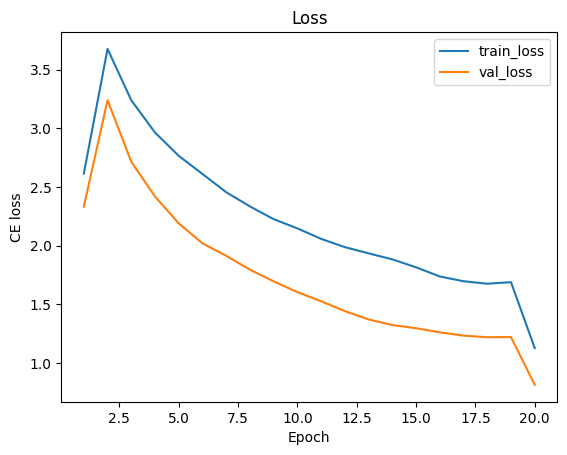

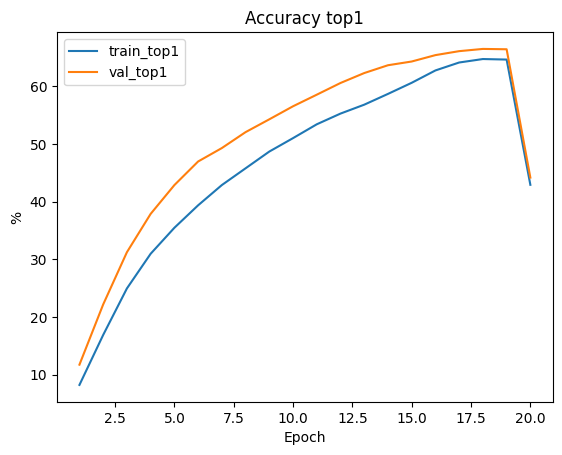

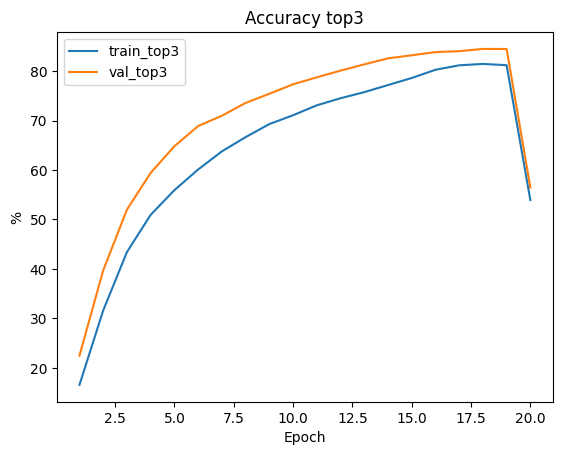

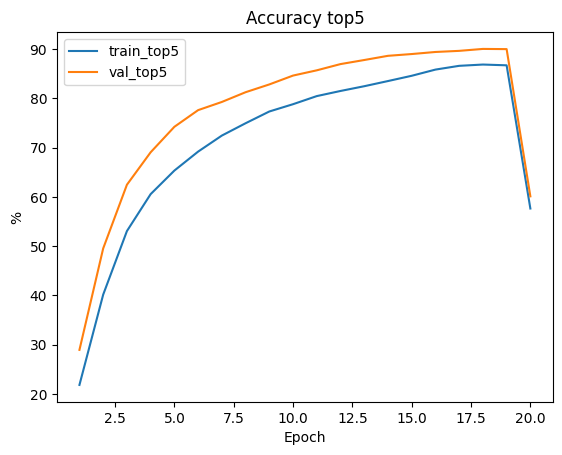

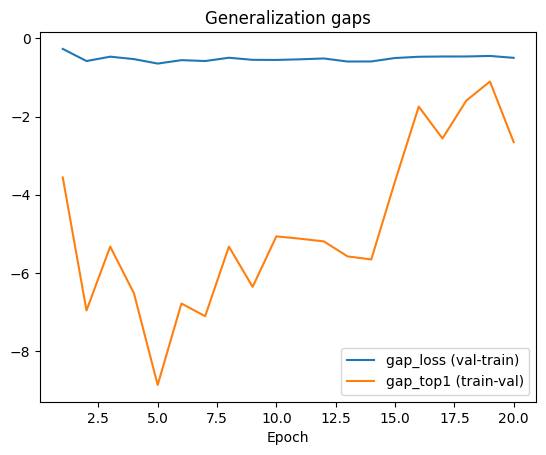

In [67]:
plot_history(history, smooth=3)
plot_gaps(history)

In [ ]:
@torch.no_grad()
def confusion_matrix(model, loader, num_classes=100, device="cuda"):
    model.eval().to(device)
    cm = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(dim=1)
        for t, p in zip(y.view(-1), pred.view(-1)):
            cm[int(t), int(p)] += 1
    return cm.cpu().numpy()

def plot_confusion_matrix(cm, class_names=None, normalize=True, max_classes=30):
    """
    Para CIFAR-100, plotear 100x100 es ilegible. Esto plotea una submatriz de las clases
    con más ejemplos o más error (simplemente toma las primeras max_classes).
    """
    cm = cm.astype(float)
    if normalize:
        row_sums = cm.sum(axis=1, keepdims=True) + 1e-12
        cm = cm / row_sums

    cm_small = cm[:max_classes, :max_classes]
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm_small, aspect="auto")
    ax.set_title(f"Confusion matrix (first {max_classes} classes)")
    ax.set_xlabel("Pred"); ax.set_ylabel("True")

    if class_names is not None:
        ax.set_xticks(range(max_classes))
        ax.set_yticks(range(max_classes))
        ax.set_xticklabels(class_names[:max_classes], rotation=90, fontsize=7)
        ax.set_yticklabels(class_names[:max_classes], fontsize=7)

    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

def top_confusions(cm, k=20):
    cm = cm.copy()
    np.fill_diagonal(cm, 0)
    pairs = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0:
                pairs.append((int(cm[i, j]), i, j))
    pairs.sort(reverse=True, key=lambda x: x[0])

    return pairs[:k]




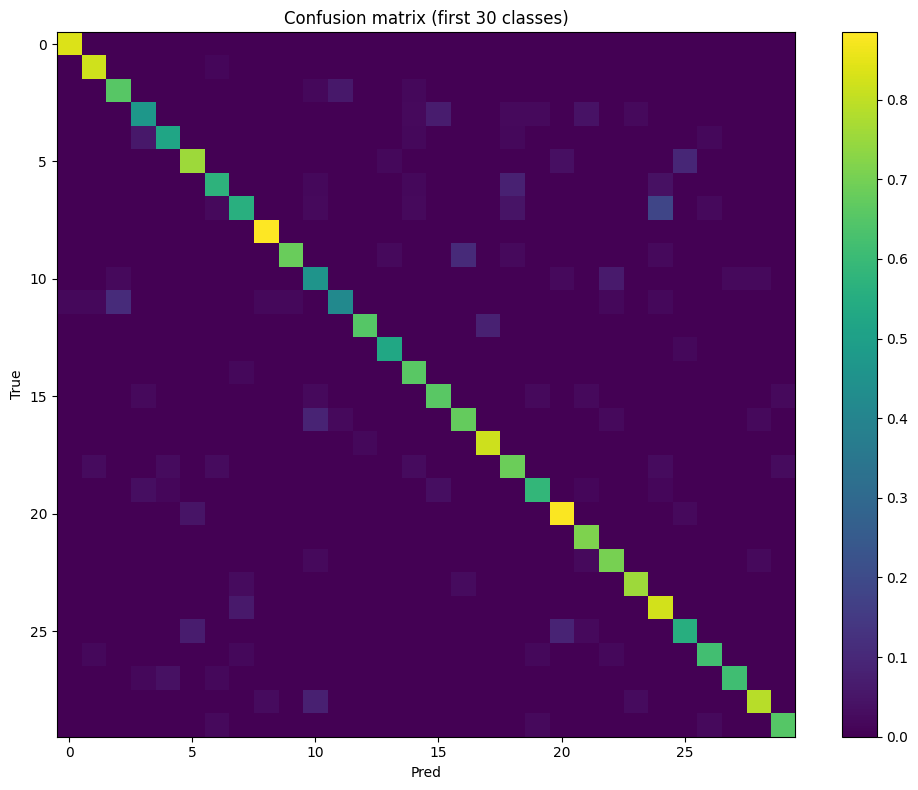

10 true= 10 pred= 61
10 true= 95 pred= 30
9 true= 13 pred= 81
9 true= 47 pred= 52
8 true= 7 pred= 24
8 true= 35 pred= 98
8 true= 55 pred= 4
7 true= 11 pred= 35
7 true= 11 pred= 46
7 true= 50 pred= 74
7 true= 71 pred= 60
7 true= 90 pred= 81
7 true= 96 pred= 52
7 true= 98 pred= 35
6 true= 11 pred= 2


In [56]:
cm = confusion_matrix(model, val_loader, num_classes=100, device="cuda")
plot_confusion_matrix(cm, class_names=None, normalize=True, max_classes=30)

for cnt, t, p in top_confusions(cm, k=15):
    print(cnt, "true=", t, "pred=", p)

In [57]:
@torch.no_grad()
def calibration_stats(model, loader, n_bins=15, device="cuda"):
    model.eval().to(device)

    confs = []
    corrects = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        probs = model(x).softmax(dim=1)
        conf, pred = probs.max(dim=1)
        confs.append(conf.detach().cpu().numpy())
        corrects.append((pred == y).detach().cpu().numpy().astype(np.float32))

    confs = np.concatenate(confs)
    corrects = np.concatenate(corrects)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(confs, bins) - 1
    acc = np.zeros(n_bins); avg_conf = np.zeros(n_bins); counts = np.zeros(n_bins)

    for b in range(n_bins):
        m = bin_ids == b
        counts[b] = m.sum()
        if counts[b] > 0:
            acc[b] = corrects[m].mean()
            avg_conf[b] = confs[m].mean()

    # Expected Calibration Error (ECE)
    ece = 0.0
    total = counts.sum() + 1e-12
    for b in range(n_bins):
        if counts[b] > 0:
            ece += (counts[b] / total) * abs(acc[b] - avg_conf[b])

    return {"bins": bins, "acc": acc, "avg_conf": avg_conf, "counts": counts, "ece": float(ece)}

def plot_reliability(calib):
    acc = calib["acc"]; avg_conf = calib["avg_conf"]; counts = calib["counts"]
    n_bins = len(acc)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.plot(avg_conf, acc, marker="o")
    ax.set_title(f"Reliability diagram (ECE={calib['ece']:.4f})")
    ax.set_xlabel("Confidence"); ax.set_ylabel("Accuracy")
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    plt.show()

    fig, ax = plt.subplots(figsize=(7, 3))
    ax.bar(np.arange(n_bins), counts)
    ax.set_title("Counts per bin")
    ax.set_xlabel("Bin"); ax.set_ylabel("Count")
    plt.show()

ECE: 0.04177738797664642


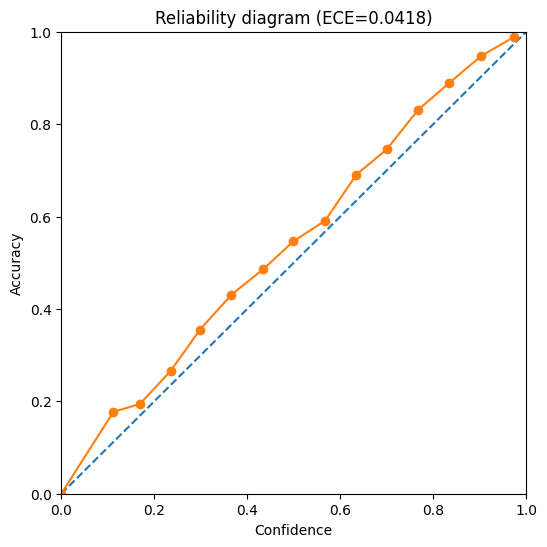

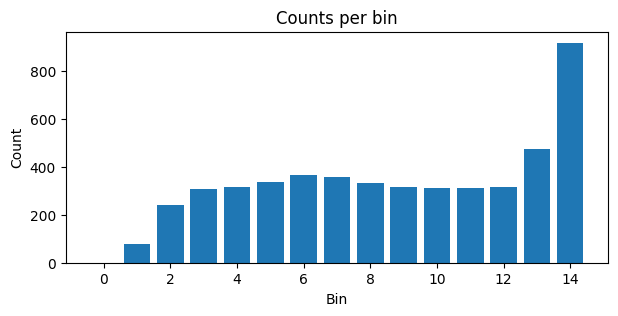

In [68]:
calib = calibration_stats(model, val_loader, n_bins=15, device="cuda")
print("ECE:", calib["ece"])
plot_reliability(calib)

In [58]:
@torch.no_grad()
def occlusion_sensitivity(
    model,
    x,                   # [1,C,H,W]
    target_class=None,   # si None usa la clase predicha
    patch=6,
    stride=3,
    baseline=0.0,
    device="cuda",):
    model.eval().to(device)
    x = x.to(device)

    logits = model(x)
    probs = logits.softmax(dim=1)
    if target_class is None:
        target_class = int(probs.argmax(dim=1).item())

    base_score = float(probs[0, target_class].item())

    _, C, H, W = x.shape
    out_h = 1 + (H - patch) // stride
    out_w = 1 + (W - patch) // stride
    heat = np.zeros((out_h, out_w), dtype=np.float32)

    for i, y0 in enumerate(range(0, H - patch + 1, stride)):
        for j, x0 in enumerate(range(0, W - patch + 1, stride)):
            x_occ = x.clone()
            x_occ[:, :, y0:y0+patch, x0:x0+patch] = baseline
            p = model(x_occ).softmax(dim=1)[0, target_class].item()
            heat[i, j] = base_score - p  # caída de prob

    return base_score, target_class, heat

def plot_occlusion_heatmap(img_chw, heat, patch=6, stride=3):
    img = img_chw.permute(1,2,0).cpu().numpy()
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(np.clip(img, 0, 1))
    # upsample heatmap a tamaño imagen (nearest)
    hH, hW = heat.shape
    up = np.kron(heat, np.ones((stride, stride)))
    ax.imshow(up, alpha=0.5)
    ax.set_title("Occlusion sensitivity (higher = more important)")
    ax.axis("off")
    plt.show()

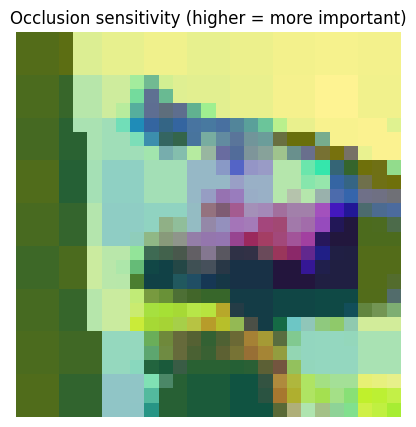

target_class: 37 base_prob: 0.12276472896337509


In [59]:
x, y = next(iter(val_loader))
x1 = x[:1]
base_score, cls, heat = occlusion_sensitivity(model, x1, patch=6, stride=3, baseline=0.0)
plot_occlusion_heatmap(x1[0].cpu(), heat, patch=6, stride=3)
print("target_class:", cls, "base_prob:", base_score)

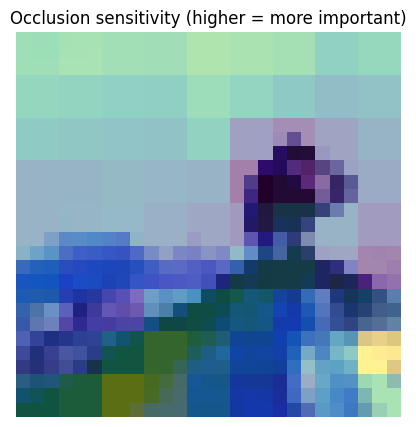

target_class: 68 base_prob: 0.46141287684440613


In [61]:
x, y = next(iter(test_loader))
x1 = x[:1]
base_score, cls, heat = occlusion_sensitivity(model, x1, patch=6, stride=3, baseline=0.0)
plot_occlusion_heatmap(x1[0].cpu(), heat, patch=6, stride=3)
print("target_class:", cls, "base_prob:", base_score)

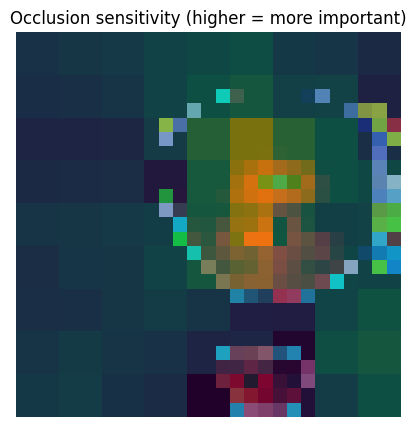

target_class: 46 base_prob: 0.31916695833206177


In [62]:
x, y = next(iter(train_loader))
x1 = x[:1]
base_score, cls, heat = occlusion_sensitivity(model, x1, patch=6, stride=3, baseline=0.0)
plot_occlusion_heatmap(x1[0].cpu(), heat, patch=6, stride=3)
print("target_class:", cls, "base_prob:", base_score)

In [63]:
def find_last_conv2d(model: nn.Module) -> nn.Conv2d:
    last = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    if last is None:
        raise RuntimeError("No Conv2d found in model.")
    return last

class GradCAM:
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.grads = None
        self.h1 = target_layer.register_forward_hook(self._forward_hook)
        self.h2 = target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out  # [B,C,H,W]

    def _backward_hook(self, module, grad_inp, grad_out):
        self.grads = grad_out[0]  # [B,C,H,W]

    def close(self):
        self.h1.remove(); self.h2.remove()

    def __call__(self, x, class_idx=None):
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)
        if class_idx is None:
            class_idx = int(logits.argmax(dim=1).item())
        score = logits[:, class_idx].sum()
        score.backward()

        A = self.activations  # [B,C,H,W]
        G = self.grads        # [B,C,H,W]
        w = G.mean(dim=(2,3), keepdim=True)   # [B,C,1,1]
        cam = (w * A).sum(dim=1, keepdim=True)  # [B,1,H,W]
        cam = F.relu(cam)
        cam = cam / (cam.amax(dim=(2,3), keepdim=True) + 1e-12)
        return cam.detach(), class_idx

def overlay_cam(img_chw, cam_1hw, alpha=0.5):
    img = img_chw.permute(1,2,0).cpu().numpy()
    cam = cam_1hw[0].cpu().numpy()
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(np.clip(img, 0, 1))
    ax.imshow(cam, alpha=alpha)
    ax.axis("off")
    plt.show()

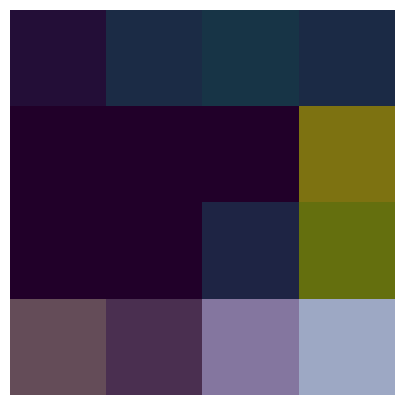

GradCAM class: 37


In [64]:
layer = find_last_conv2d(model)
gc = GradCAM(model, layer)

x, y = next(iter(val_loader))
x1 = x[:1].cuda()
cam, cls = gc(x1, class_idx=None)
overlay_cam(x1[0].cpu(), cam[0])  # cam[0] es [1,H,W]
print("GradCAM class:", cls)

gc.close()

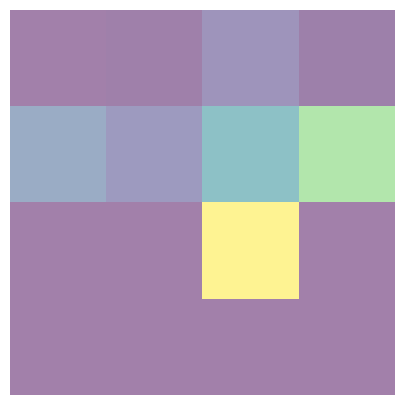

GradCAM class: 68


In [65]:
layer = find_last_conv2d(model)
gc = GradCAM(model, layer)

x, y = next(iter(test_loader))
x1 = x[:1].cuda()
cam, cls = gc(x1, class_idx=None)
overlay_cam(x1[0].cpu(), cam[0])
print("GradCAM class:", cls)

gc.close()

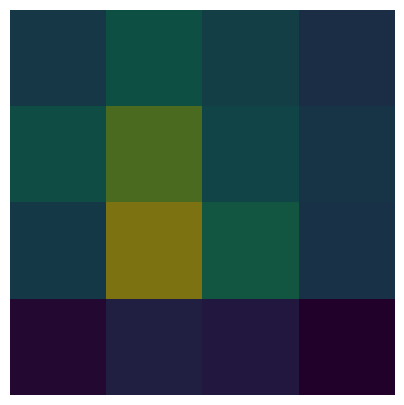

GradCAM class: 88


In [66]:
layer = find_last_conv2d(model)
gc = GradCAM(model, layer)

x, y = next(iter(train_loader))
x1 = x[:1].cuda()
cam, cls = gc(x1, class_idx=None)
overlay_cam(x1[0].cpu(), cam[0])
print("GradCAM class:", cls)

gc.close()